In [13]:
# scripts/select_asr_samples_simple.py
#!/usr/bin/env python3
from __future__ import annotations

import csv
import shutil
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Set, Tuple
import glob as _glob
import pandas as pd

# ========= 配置（按需修改） =========
CSV_PATH = Path("12089-recommended-screening-list.csv")
SRC_DIR = Path("data_core/cif/CSD-modified/cifs/CR/ASR")
DST_DIR = Path("data_core/cif/CSD-modified/cifs/CR/ASR_selection")
ID_COL = "core-mof-id"
ONLY_KEEP_ASR = True         # 仅保留包含 "[ASR]" 的 ID
DRY_RUN = False              # 先试运行不复制文件
OVERWRITE = True             # 允许覆盖已存在文件
REPORT_NAME = "ASR_selection_report.csv"
# ==================================

@dataclass
class MatchResult:
    id: str
    status: str   # "copied" | "missing" | "ambiguous" | "dry-run" | "error"
    src_path: Optional[Path]
    dst_path: Optional[Path]
    note: str = ""

def read_ids(csv_path: Path, id_col: str) -> List[str]:
    df = pd.read_csv(csv_path)
    if id_col not in df.columns:
        raise KeyError(f"列 '{id_col}' 不存在。可用列：{list(df.columns)}")
    raw = (
        df[id_col]
        .dropna()
        .astype(str)
        .str.strip()
        .tolist()
    )
    seen: Set[str] = set()
    uniq: List[str] = []
    for x in raw:
        if x and x not in seen:
            uniq.append(x)
            seen.add(x)
    return uniq

def try_exact(src_dir: Path, id_value: str) -> Optional[Path]:
    p = src_dir / f"{id_value}.cif"
    return p if p.is_file() else None

def try_glob_single(src_dir: Path, id_value: str) -> Tuple[Optional[Path], int]:
    escaped = _glob.escape(id_value)  # 避免方括号等元字符被解释
    hits = [p for p in src_dir.glob(f"*{escaped}*.cif") if p.is_file()]
    if len(hits) == 1:
        return hits[0], 1
    return None, len(hits)

def ensure_dir(d: Path) -> None:
    d.mkdir(parents=True, exist_ok=True)

def copy_file(src: Path, dst_dir: Path, overwrite: bool = True) -> Path:
    ensure_dir(dst_dir)
    dst = dst_dir / src.name
    if dst.exists() and not overwrite:
        # 不覆盖：直接返回目标路径
        return dst
    shutil.copy2(src, dst)
    return dst

def write_report(dst_dir: Path, results: List[MatchResult], filename: str) -> Path:
    ensure_dir(dst_dir)
    report = dst_dir / filename
    with report.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["id", "status", "src_path", "dst_path", "note"])
        for r in results:
            w.writerow([
                r.id,
                r.status,
                str(r.src_path) if r.src_path else "",
                str(r.dst_path) if r.dst_path else "",
                r.note,
            ])
    return report

# ========= 顶层执行 =========
if not CSV_PATH.is_file():
    raise FileNotFoundError(f"CSV 未找到：{CSV_PATH}")
if not SRC_DIR.is_dir():
    raise NotADirectoryError(f"源目录未找到：{SRC_DIR}")

ids = read_ids(CSV_PATH, ID_COL)
if ONLY_KEEP_ASR:
    ids = [i for i in ids if "[ASR]" in i]

results: List[MatchResult] = []
copied = missing = ambiguous = errors = dry = 0

for id_value in ids:
    try:
        # 精确匹配优先
        p = try_exact(SRC_DIR, id_value)
        note = "exact"
        if not p:
            # 单一模糊回退
            p, nhits = try_glob_single(SRC_DIR, id_value)
            if not p and nhits == 0:
                results.append(MatchResult(id_value, "missing", None, None, "no match"))
                missing += 1
                continue
            if not p and nhits > 1:
                results.append(MatchResult(id_value, "ambiguous", None, None, f"{nhits} candidates"))
                ambiguous += 1
                continue
            note = "glob-fallback"

        if DRY_RUN:
            results.append(MatchResult(id_value, "dry-run", p, DST_DIR / p.name, note))
            dry += 1
        else:
            dst = copy_file(p, DST_DIR, overwrite=OVERWRITE)
            results.append(MatchResult(id_value, "copied", p, dst, note))
            copied += 1

    except Exception as e:  # 防止个别异常中断全流程
        results.append(MatchResult(id_value, "error", None, None, note=str(e)))
        errors += 1

report_path = write_report(DST_DIR if not DRY_RUN else Path.cwd(), results, REPORT_NAME)

total = len(ids)
print(f"[DONE] processed: {total}")
print(f"       copied: {copied}, missing: {missing}, ambiguous: {ambiguous}, dry-run: {dry}, errors: {errors}")
print(f"       report: {report_path}")


[DONE] processed: 8856
       copied: 5604, missing: 3170, ambiguous: 82, dry-run: 0, errors: 0
       report: data_core\cif\CSD-modified\cifs\CR\ASR_selection\ASR_selection_report.csv


In [14]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import logging
# 这两个 import 用你项目里实际模块路径
from cgcnn2.util import cgcnn_pred, Normalizer
from cgcnn2.data import CIFData_NoTarget, collate_pool

MODEL = "R2_0.9384/best_model_0.9384.ckpt"            
CIF_DIR = "data_core/cif/CSD-modified/cifs/CR/ASR_selection"     
OUT_CSV = "data_core/cif/CSD-modified/cifs/CR/ASR_prediction.csv"

def main():
    # 统计总数，用于进度条总长度
    ds_for_len = CIFData_NoTarget(CIF_DIR)
    total = len(ds_for_len)

    # === 进度条：捕获 cgcnn_descriptor 的每步日志 "index: ..." 来更新 ===
    pbar = tqdm(total=total, desc="Inference on ASR", unit="cif")

    class TqdmHandler(logging.Handler):
        def emit(self, record):
            msg = record.getMessage()
            # cgcnn_descriptor 每处理一个样本通常会打印 "index: N | cif id: ... | prediction: ..."
            if msg.startswith("index: "):
                pbar.update(1)

    logging.basicConfig(level=logging.INFO)         # 确保能收到 info 日志
    handler = TqdmHandler()
    logging.getLogger().addHandler(handler)

    # 1) 推理（注意：这里不改包内代码，直接利用 verbose 的日志更新进度条）
    preds, feats = cgcnn_pred(
        model_path=MODEL,
        full_set=CIF_DIR,
        verbose=101,         # >=10 才会逐样本 logging.info；保持你之前的 101
        cuda=False,          # 你当前是 CPU 版 torch
        num_workers=0,       # Windows 下防止多进程问题
    )

    # 关闭并移除进度条 handler
    pbar.close()
    logging.getLogger().removeHandler(handler)

    # 2) 取 ID（顺序一致；再来一个小进度条）
    ids = []
    ds = CIFData_NoTarget(CIF_DIR)
    loader = DataLoader(ds, batch_size=1, shuffle=False, collate_fn=collate_pool, num_workers=0)
    for batch in tqdm(loader, total=len(ds), desc="Collect IDs", unit="cif"):
        cif_id = batch[-1]
        ids.append(cif_id[0] if isinstance(cif_id, list) else cif_id)



    pd.DataFrame({"id": ids, "prediction": preds}).to_csv(OUT_CSV, index=False)
    print(f"done -> {OUT_CSV}  （共 {len(ids)} 条）")

if __name__ == "__main__":
    # Windows 下的安全入口（即便 num_workers=0，加上更稳）
    import multiprocessing as mp
    mp.freeze_support()
    main()

Inference on ASR:   0%|          | 0/5590 [00:00<?, ?cif/s]

INFO:root:=> Loaded model from 'R2_0.9384/best_model_0.9384.ckpt' (epoch 265, validation MSE=10.9886)
INFO:root:index: 1 | cif id: 0000[Ag][nan]3[ASR]1 | prediction: 48.99305725097656
INFO:root:index: 2 | cif id: 0000[Ag][sql]2[ASR]1 | prediction: 23.494396209716797
INFO:root:index: 3 | cif id: 0000[Ag][sra]3[ASR]1 | prediction: 65.85700988769531
INFO:root:index: 4 | cif id: 0000[AsCd][cds]3[ASR]1 | prediction: -0.7343142032623291
INFO:root:index: 5 | cif id: 0000[Cd][bcu]3[ASR]1 | prediction: 11.568113327026367
INFO:root:index: 6 | cif id: 0000[Cd][deh]3[ASR]1 | prediction: 11.330617904663086
INFO:root:index: 7 | cif id: 0000[Cd][dia]3[ASR]1 | prediction: 12.962089538574219
INFO:root:index: 8 | cif id: 0000[Cd][fsc]3[ASR]1 | prediction: 17.00934600830078
INFO:root:index: 9 | cif id: 0000[Cd][nan]2[ASR]1 | prediction: 23.656143188476562
INFO:root:index: 10 | cif id: 0000[Cd][nan]2[ASR]2 | prediction: 17.231887817382812
INFO:root:index: 11 | cif id: 0000[Cd][nan]3[ASR]1 | prediction: 11

Collect IDs:   0%|          | 0/5590 [00:00<?, ?cif/s]

done -> data_core/cif/CSD-modified/cifs/CR/ASR_prediction.csv  （共 5590 条）


In [22]:


from __future__ import annotations
from pathlib import Path
from typing import List, Tuple, Optional, Dict
import pandas as pd
import numpy as np

PRED_PATH = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction.csv")                       # 你的预测结果 CSV
FEAT_PATH = Path("data_core/cif/CSD-modified/CR_data_CSD_modified_20250227.csv")  # 已上传的特征数据
OUT_PATH  = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")


# 连接键候选（按优先级）
PRED_KEY_CANDIDATES: List[str] = ["core-mof-id", "coreid", "name", "refcode", "mofid-v1", "mofid-v2", "id"]
FEAT_KEY_CANDIDATES: List[str] = ["coreid", "name", "refcode", "mofid-v1", "mofid-v2"]

def _normalize_series(s: pd.Series) -> pd.Series:
    """Why: 统一大小写与空白，提升键对齐的鲁棒性。"""
    return (
        s.astype(str)
         .str.strip()
         .str.replace(r"\s+", " ", regex=True)
         .str.replace('"', "", regex=False)
         .str.replace("'", "", regex=False)
         .str.lower()
    )

def _best_join_key(
    df_pred: pd.DataFrame, df_feat: pd.DataFrame,
    pred_keys: List[str], feat_keys: List[str]
) -> Optional[Tuple[str, str, int]]:
    """返回 (pred_key, feat_key, matches)；若无可用键返回 None。"""
    scores: List[Tuple[str, str, int]] = []
    pred_cols = set(df_pred.columns)
    feat_cols = set(df_feat.columns)
    for pk in pred_keys:
        if pk not in pred_cols:
            continue
        left = _normalize_series(df_pred[pk]).rename("__lk__")
        for fk in feat_keys:
            if fk not in feat_cols:
                continue
            right = _normalize_series(df_feat[fk]).rename("__rk__")
            # 估算匹配数（集合交集大小）
            matches = len(set(left.dropna()) & set(right.dropna()))
            if matches > 0:
                scores.append((pk, fk, matches))
    if not scores:
        return None
    # 先按匹配数降序，其次优先 core-mof-id <-> coreid
    def _rank(item: Tuple[str, str, int]) -> Tuple[int, int]:
        pk, fk, m = item
        pri = 1 if (pk == "core-mof-id" and fk == "coreid") else 0
        return (m, pri)
    best = max(scores, key=_rank)
    return best

# ======= 顶层步骤（无 main） =======
if not FEAT_PATH.is_file():
    raise FileNotFoundError(f"特征 CSV 不存在: {FEAT_PATH.resolve()}")
if not PRED_PATH.is_file():
    raise FileNotFoundError(f"预测 CSV 不存在: {PRED_PATH.resolve()}")

pred = pd.read_csv(PRED_PATH)
feat = pd.read_csv(FEAT_PATH)

best = _best_join_key(pred, feat, PRED_KEY_CANDIDATES, FEAT_KEY_CANDIDATES)
if best is None:
    raise RuntimeError("无法找到可用连接键，请检查两侧主键列名或内容是否可对齐。")

pk, fk, est_matches = best

# 规范化连接键副本，避免污染原始列
pred["_join_key_"] = _normalize_series(pred[pk])
feat["_join_key_"] = _normalize_series(feat[fk])

# 需合并的特征列（排除键）
exclude_cols = {"_join_key_", fk}
feat_cols = [c for c in feat.columns if c not in exclude_cols]

# 重名列处理：为与预测集同名的特征列加后缀
dup_cols = set(pred.columns) & set(feat_cols)
feat_renamer: Dict[str, str] = {c: f"{c}_feat" for c in dup_cols}
feat_renamed = feat.rename(columns=feat_renamer)

# 执行合并
merged = pred.merge(
    feat_renamed[["_join_key_"] + [c if c not in feat_renamer else feat_renamer[c] for c in feat_cols]],
    on="_join_key_",
    how="left",
    validate="m:1"  # Why: 预测侧通常多行对一个特征实体，避免 1:m 膨胀
)

# 清理中间列
merged.drop(columns=["_join_key_"], inplace=True)
pred.drop(columns=["_join_key_"], errors="ignore", inplace=True)
feat.drop(columns=["_join_key_"], errors="ignore", inplace=True)

# 统计与保存
n_pred = len(pred)
n_matched_rows = merged.shape[0] - merged.isna().all(axis=1).sum()
# 更精确地数“成功对齐”的记录：看是否从 feat 引入了至少一列非空
feat_added_cols = [c for c in merged.columns if c in feat_renamer.values() or (c in feat_cols and c not in pred.columns)]
if feat_added_cols:
    matched_mask = merged[feat_added_cols].notna().any(axis=1)
    n_enriched = int(matched_mask.sum())
else:
    n_enriched = 0

merged.to_csv(OUT_PATH, index=False)

print(f"[KEY] pred.{pk}  <->  feat.{fk}  (Estimated number of unique keys that can be joined: {est_matches})")
print(f"[ROWS] pred: {n_pred}  → merged: {len(merged)}")
print(f"[ENRICHED] Add at least one row with non-empty features: {n_enriched}")
print(f"[OUT] {OUT_PATH.resolve()}")



[KEY] pred.id  <->  feat.coreid  (Estimated number of unique keys that can be joined: 5590)
[ROWS] pred: 5590  → merged: 5590
[ENRICHED] Add at least one row with non-empty features: 5590
[OUT] D:\pycharm\py_project\CGCNN2_data_science_project\data_core\cif\CSD-modified\cifs\CR\ASR_prediction_with_features.csv


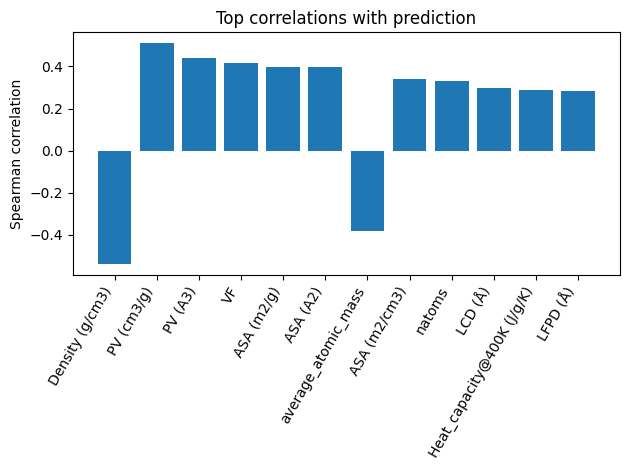

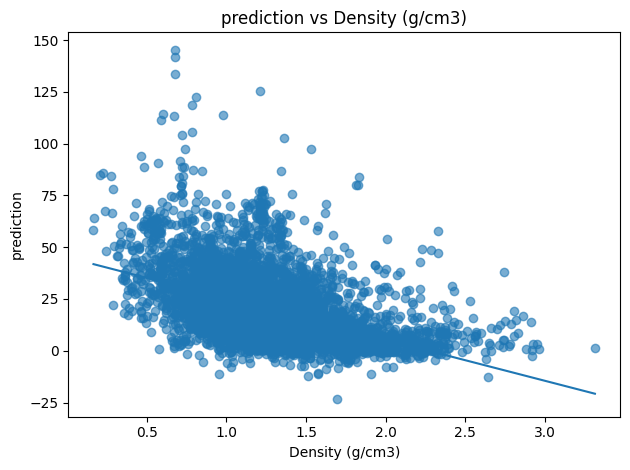

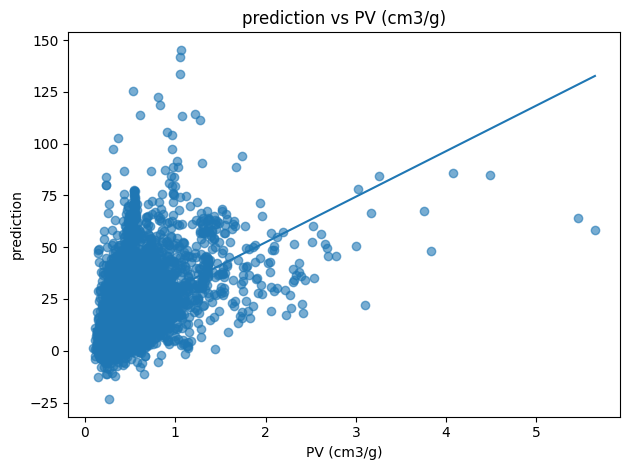

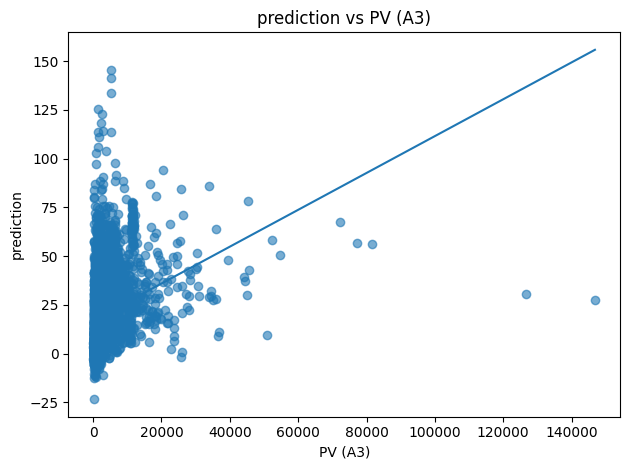

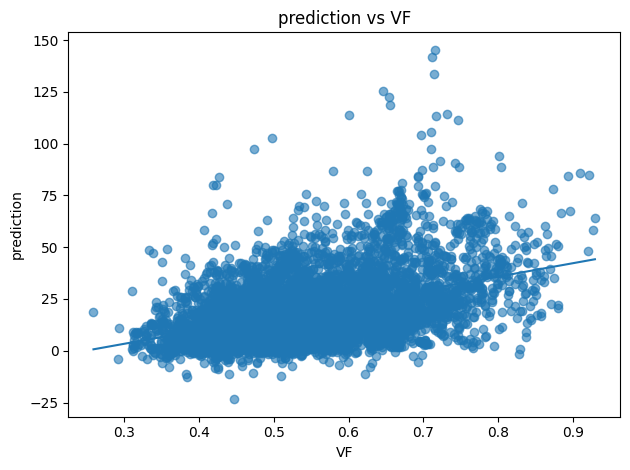

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25652\4083247454.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(groups, labels=labels, showfliers=False); plt.xlabel("structure_dimension"); plt.ylabel(PRED_COL); plt.title(f"{PRED_COL} by structure_dimension"); plt.tight_layout(); plt.show()


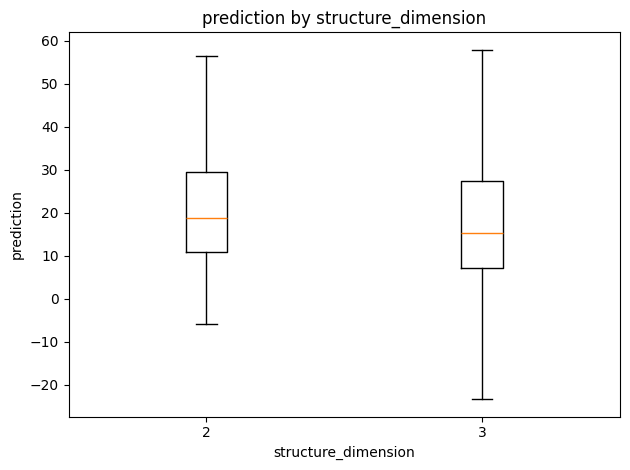

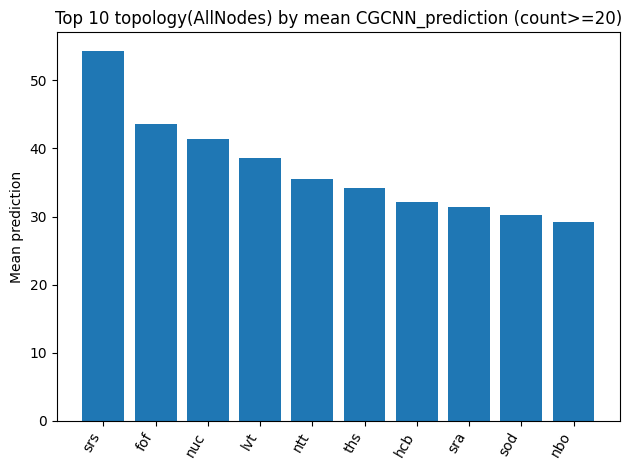

Report saved: data_core\cif\CSD-modified\cifs\CR\ASR_interpretability_report.xlsx


In [23]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

PRED_COL = "prediction"
NUM_FEATURES = ["LCD (Å)","PLD (Å)","LFPD (Å)","Density (g/cm3)","ASA (A2)","ASA (m2/cm3)","ASA (m2/g)","NASA (A2)","NASA (m2/cm3)","NASA (m2/g)","PV (A3)","VF","PV (cm3/g)","NAV (A3)","NAV_VF","NPV (cm3/g)","average_atomic_mass","Heat_capacity@300K (J/g/K)","Heat_capacity@350K (J/g/K)","Heat_capacity@400K (J/g/K)","natoms"]
CAT_FEATURES = ["structure_dimension","catenation","dimension_by_topo","topology(SingleNodes)","topology(AllNodes)","topology(SingleNodes)-zeo","topology(AllNodes)-zeo","Metal Types","Has OMS","OMS Types","KH_Classes"]

CSV_IN = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")
REPORT_XLSX = Path("data_core/cif/CSD-modified/cifs/CR/ASR_interpretability_report.xlsx")

df = pd.read_csv(CSV_IN)
for c in [PRED_COL] + [x for x in NUM_FEATURES if x in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.loc[~df[PRED_COL].isna()].copy()


cors=[]
for c in [x for x in NUM_FEATURES if x in df.columns]:
    s = df[[PRED_COL,c]].dropna()
    if len(s)>=5:
        cors.append((c, s[PRED_COL].corr(s[c], method="spearman"), s[PRED_COL].corr(s[c], method="pearson"), len(s)))
cor_df = pd.DataFrame(cors, columns=["feature","spearman","pearson","n"]).sort_values("spearman", key=lambda s: s.abs(), ascending=False)


cat_summaries={}
for c in [x for x in CAT_FEATURES if x in df.columns]:
    cat_summaries[c] = df.groupby(c, dropna=False)[PRED_COL].agg(["count","mean","median","std"]).sort_values("mean", ascending=False)


with pd.ExcelWriter(REPORT_XLSX) as xw:
    cor_df.to_excel(xw, sheet_name="numeric_correlations", index=False)
    for c,g in cat_summaries.items():
        g.to_excel(xw, sheet_name=c[:28])

# 可视化（matplotlib，单图，无配色）
top_k = cor_df.head(12)
plt.figure(); plt.bar(top_k["feature"], top_k["spearman"]); plt.xticks(rotation=60, ha="right"); plt.ylabel("Spearman correlation"); plt.title("Top correlations with prediction"); plt.tight_layout(); plt.show()
for c in top_k["feature"][:4]:
    s = df[[PRED_COL,c]].dropna()
    if len(s)>=5:
        plt.figure(); plt.scatter(s[c], s[PRED_COL], alpha=0.6)
        try:
            z=np.polyfit(s[c], s[PRED_COL], 1); xs=np.linspace(s[c].min(), s[c].max(), 100); plt.plot(xs, np.polyval(z,xs))
        except Exception: pass
        plt.xlabel(c); plt.ylabel(PRED_COL); plt.title(f"{PRED_COL} vs {c}"); plt.tight_layout(); plt.show()
if "structure_dimension" in df.columns:
    groups=[g[PRED_COL].dropna().values for _,g in df.groupby("structure_dimension")]
    labels=[str(k) for k,_ in df.groupby("structure_dimension")]
    if len(groups)>=2:
        plt.figure(); plt.boxplot(groups, labels=labels, showfliers=False); plt.xlabel("structure_dimension"); plt.ylabel(PRED_COL); plt.title(f"{PRED_COL} by structure_dimension"); plt.tight_layout(); plt.show()
tc="topology(AllNodes)"
if tc in df.columns:
    g=df.groupby(tc)[PRED_COL].agg(["count","mean"]).sort_values("mean", ascending=False)
    g=g[g["count"]>=20].head(10)
    if not g.empty:
        plt.figure(); plt.bar(g.index.astype(str), g["mean"]); plt.xticks(rotation=60, ha="right"); plt.ylabel("Mean prediction"); plt.title(f"Top {len(g)} {tc} by mean CGCNN_prediction (count>=20)"); plt.tight_layout(); plt.show()



print(f"Report saved: {REPORT_XLSX}")


## 对数或者标准化

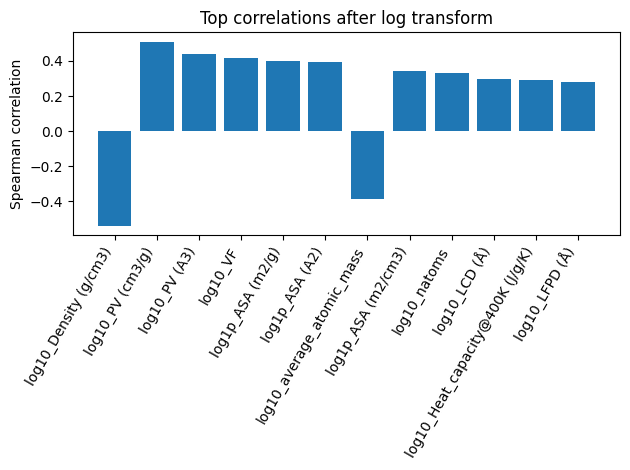

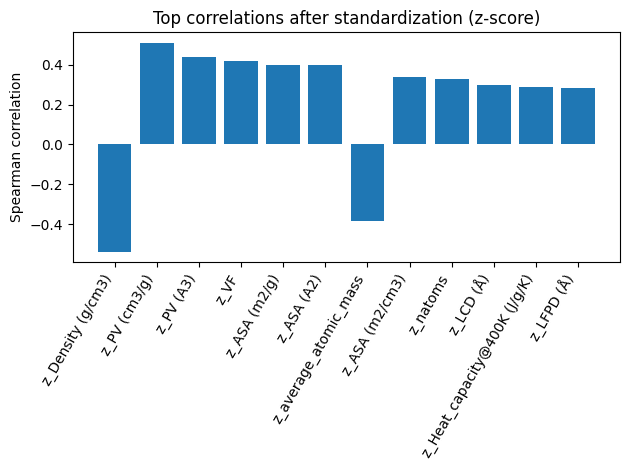

WindowsPath('data_core/cif/CSD-modified/cifs/CR/ASR_correlation_log_std.xlsx')

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


# ---------------- Config ----------------
CSV_IN = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")
PRED_COL = "prediction"
NUM_FEATURES = [
    "LCD (Å)","PLD (Å)","LFPD (Å)","Density (g/cm3)",
    "ASA (A2)","ASA (m2/cm3)","ASA (m2/g)",
    "NASA (A2)","NASA (m2/cm3)","NASA (m2/g)",
    "PV (A3)","VF","PV (cm3/g)",
    "NAV (A3)","NAV_VF","NPV (cm3/g)",
    "average_atomic_mass",
    "Heat_capacity@300K (J/g/K)","Heat_capacity@350K (J/g/K)","Heat_capacity@400K (J/g/K)",
    "natoms"
]
OUT_XLSX = Path("data_core/cif/CSD-modified/cifs/CR/ASR_correlation_log_std.xlsx")

# ---------------- Load ----------------
df = pd.read_csv(CSV_IN)
for c in [PRED_COL] + NUM_FEATURES:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.loc[~df[PRED_COL].isna()].copy()

avail = [c for c in NUM_FEATURES if c in df.columns]

# ---------------- Helpers ----------------
def corr_table(frame: pd.DataFrame, cols: list[str], y: str) -> pd.DataFrame:
    rows = []
    for c in cols:
        s = frame[[y, c]].dropna()
        if len(s) < 5:
            continue
        rows.append((c,
                     s[y].corr(s[c], method="spearman"),
                     s[y].corr(s[c], method="pearson"),
                     len(s)))
    out = pd.DataFrame(rows, columns=["feature","spearman","pearson","n"])
    return out.sort_values("spearman", key=lambda s: s.abs(), ascending=False)

# ---------------- Build transformed features ----------------
df_t = df.copy()

# Log transforms (safe):
log_map = {}  # feature -> applied rule
for c in avail:
    x = df_t[c].dropna()
    if x.empty:
        continue
    mn = x.min()
    if mn > 0:
        df_t[f"log10_{c}"] = np.log10(df_t[c])
        log_map[c] = "log10(x)"
    elif mn >= 0:
        df_t[f"log1p_{c}"] = np.log1p(df_t[c])
        log_map[c] = "log1p(x)"
    else:
        # shift so min becomes small positive (1e-6 safety)
        shift = -mn + 1e-6
        df_t[f"log10_{c}"] = np.log10(df_t[c] + shift)
        log_map[c] = f"log10(x+{shift:.3g})"

# Standardization (z-score) on original features
for c in avail:
    mu = df_t[c].mean(skipna=True)
    sd = df_t[c].std(skipna=True)
    if pd.notna(sd) and sd > 0:
        df_t[f"z_{c}"] = (df_t[c] - mu) / sd

# ---------------- Compute correlations ----------------
orig_cor = corr_table(df_t, avail, PRED_COL)
log_cols = [k for k in df_t.columns if k.startswith("log10_") or k.startswith("log1p_")]
log_cor = corr_table(df_t, log_cols, PRED_COL)
z_cols = [k for k in df_t.columns if k.startswith("z_")]
z_cor = corr_table(df_t, z_cols, PRED_COL)

# ---------------- Save report ----------------
with pd.ExcelWriter(OUT_XLSX) as xw:
    orig_cor.to_excel(xw, sheet_name="original", index=False)
    log_cor.to_excel(xw, sheet_name="log_transformed", index=False)
    z_cor.to_excel(xw, sheet_name="standardized(z)", index=False)
    # also include the mapping of log rules
    if log_map:
        pd.DataFrame({"feature": list(log_map.keys()), "log_rule": list(log_map.values())}).to_excel(xw, sheet_name="log_rules", index=False)

# ---------------- Visualizations ----------------
# Top-12 absolute Spearman after log
if not log_cor.empty:
    top_k = log_cor.head(12)
    plt.figure()
    plt.bar(top_k["feature"], top_k["spearman"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Spearman correlation")
    plt.title("Top correlations after log transform")
    plt.tight_layout()
    plt.show()

# Top-12 absolute Spearman after standardization (should equal original for pearson, but Spearman may reorder if ties broken)
if not z_cor.empty:
    top_kz = z_cor.head(12)
    plt.figure()
    plt.bar(top_kz["feature"], top_kz["spearman"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Spearman correlation")
    plt.title("Top correlations after standardization (z-score)")
    plt.tight_layout()
    plt.show()

# ---------------- Present tables ----------------


OUT_XLSX


[Surrogate ridge] R^2=0.474  MAE=8.7145  n_test=800
[OUT] data_core\cif\CSD-modified\cifs\CR\asr_shap_outputs_fix\shap_summary.csv
[OUT] data_core\cif\CSD-modified\cifs\CR\asr_shap_outputs_fix\shap_topology_allnodes.csv


D:\pycharm\py_project\CGCNN2_data_science_project\.venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


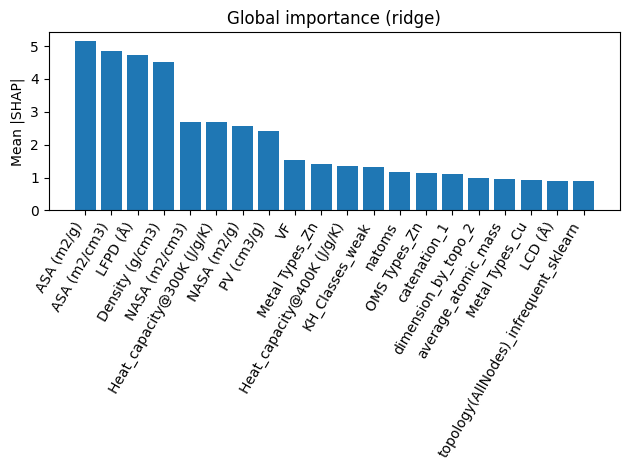

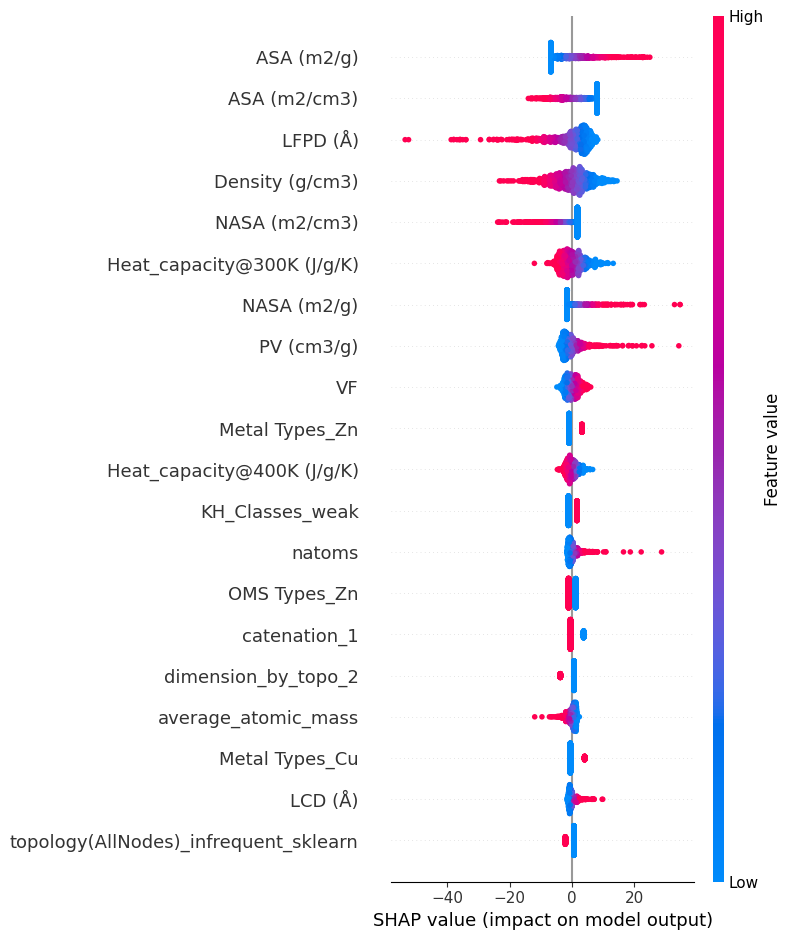

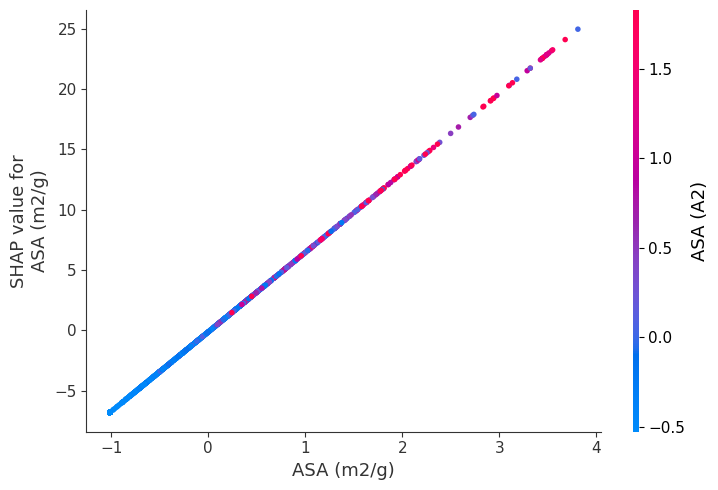

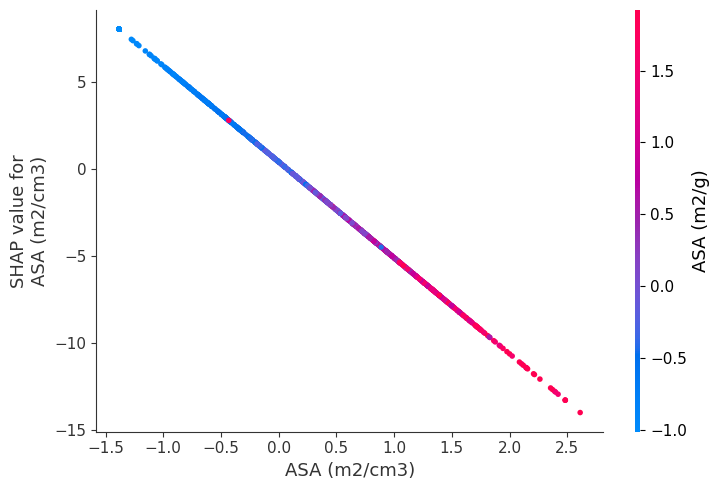

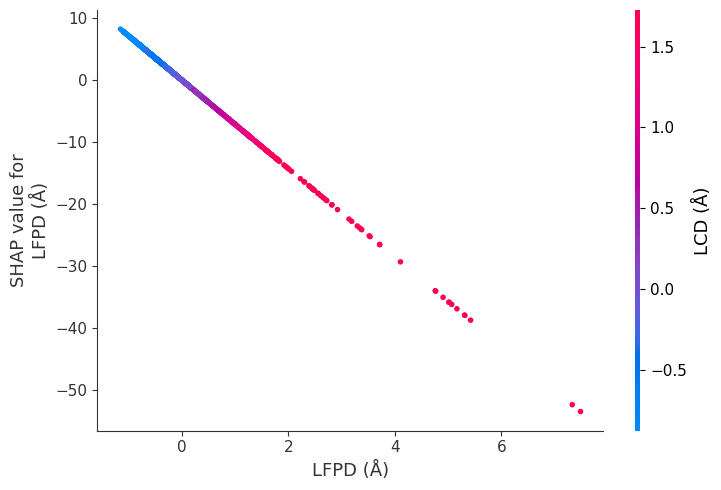

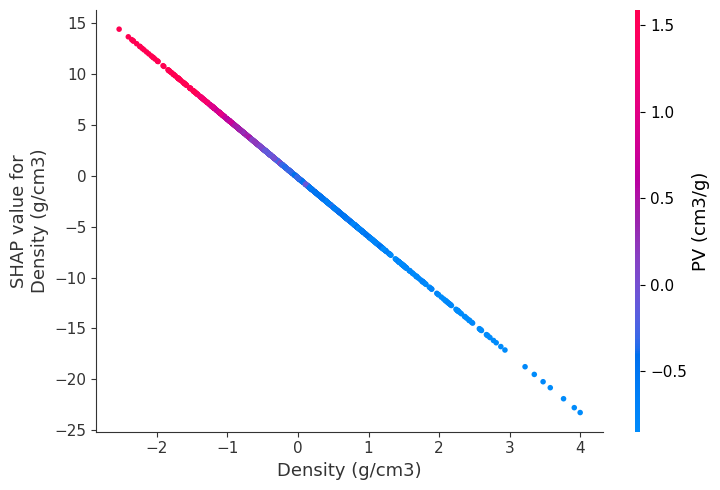

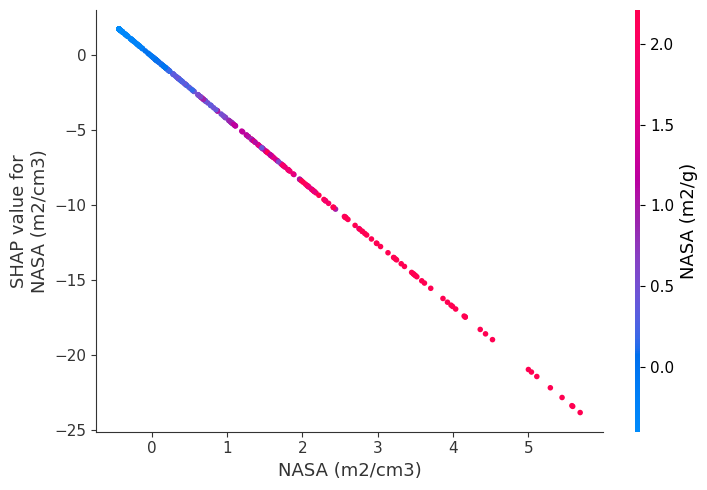

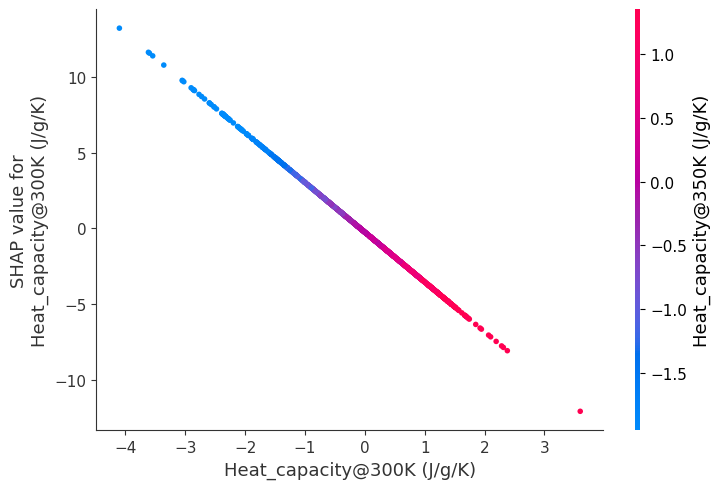

[DONE] All artifacts in: D:\pycharm\py_project\CGCNN2_data_science_project\data_core\cif\CSD-modified\cifs\CR\asr_shap_outputs_fix


In [25]:
# scripts/asr_shap_analysis.py
#!/usr/bin/env python3
"""
SHAP analysis for CGCNN predictions (surrogate model).
- Two modes: 'ridge' (fast, linear) or 'rf' (tree, nonlinear).
- Handles numeric + categorical features (topology, structure, metals, OMS).
- Outputs CSV + plots; includes model fidelity (R^2/MAE).
"""

from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ===================== Config =====================
CSV_IN = Path(CSV_IN)
TARGET = "prediction"

# Numeric features (as requested)
NUM_FEATURES = [
    "LCD (Å)","PLD (Å)","LFPD (Å)","Density (g/cm3)",
    "ASA (A2)","ASA (m2/cm3)","ASA (m2/g)",
    "NASA (A2)","NASA (m2/cm3)","NASA (m2/g)",
    "PV (A3)","VF","PV (cm3/g)",
    "NAV (A3)","NAV_VF","NPV (cm3/g)",
    "average_atomic_mass",
    "Heat_capacity@300K (J/g/K)","Heat_capacity@350K (J/g/K)","Heat_capacity@400K (J/g/K)",
    "natoms"
]

# Categorical features (topology/dimension/etc.)
CAT_FEATURES = [
    "structure_dimension","catenation","dimension_by_topo",
    "topology(SingleNodes)","topology(AllNodes)","topology(SingleNodes)-zeo","topology(AllNodes)-zeo",
    "Metal Types","Has OMS","OMS Types","KH_Classes"
]

# Choose surrogate: "ridge" (fast) or "rf" (nonlinear)
SURROGATE = "ridge"          # "ridge" (fast, linear) | "rf" 
TRAIN_MAX_N = 4000
SHAP_SAMPLE_N = 1200
OHE_MIN_FREQ = 20
MAKE_PLOTS = True
OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/asr_shap_outputs_fix"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- Load ----------------
df = pd.read_csv(CSV_IN)
num_cols = [c for c in NUM_FEATURES if c in df.columns]
cat_cols = [c for c in CAT_FEATURES if c in df.columns]
df = df[[TARGET] + num_cols + cat_cols].copy()
for c in num_cols + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.loc[~df[TARGET].isna()].reset_index(drop=True)
if len(df) > TRAIN_MAX_N:
    df = df.sample(n=TRAIN_MAX_N, random_state=42).reset_index(drop=True)

X = df[num_cols + cat_cols]
y = df[TARGET].values

# ---------------- Preprocess (force DENSE) ----------------
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

ohe = OneHotEncoder(
    handle_unknown="ignore",
                  
    sparse_output=False,       
    min_frequency=OHE_MIN_FREQ
)

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    sparse_threshold=0.0  
)

# ---------------- Model ----------------
if SURROGATE == "ridge":
    model = Ridge(alpha=1.0, random_state=42)
elif SURROGATE == "rf":
    model = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
else:
    raise ValueError("SURROGATE must be 'ridge' or 'rf'")

pipe = Pipeline([("pre", pre), ("model", model)])

# ---------------- Train & Eval ----------------
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_tr, y_tr)
y_hat = pipe.predict(X_te)
print(f"[Surrogate {SURROGATE}] R^2={r2_score(y_te, y_hat):.3f}  MAE={mean_absolute_error(y_te, y_hat):.4f}  n_test={len(y_te)}")

# ---------------- Transform & DENSIFY ----------------
pre_fitted = pipe.named_steps["pre"]
Xt_all = pre_fitted.transform(X)


try:
    from scipy import sparse as sp
    if sp.issparse(Xt_all):
        Xt_all = Xt_all.toarray()
except Exception:
    
    if hasattr(Xt_all, "toarray"):
        Xt_all = Xt_all.toarray()

# 列名
feat_names: list[str] = []
if num_cols: feat_names.extend(num_cols)
if cat_cols:
    ohe_fitted = pre_fitted.named_transformers_["cat"].named_steps["onehot"]
    feat_names.extend(list(ohe_fitted.get_feature_names_out(cat_cols)))

# ---------------- SHAP ----------------
import shap

if SURROGATE == "ridge":
    explainer = shap.LinearExplainer(pipe.named_steps["model"], Xt_all, feature_perturbation="interventional")
else:
    explainer = shap.TreeExplainer(pipe.named_steps["model"])

n = min(SHAP_SAMPLE_N, Xt_all.shape[0])
idx = np.random.RandomState(42).choice(Xt_all.shape[0], size=n, replace=False)
shap_values = explainer.shap_values(Xt_all[idx])

mean_abs = np.abs(shap_values).mean(axis=0)
summary = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=False)
summary.to_csv(OUT_DIR / "shap_summary.csv", index=False)
print(f"[OUT] {OUT_DIR/'shap_summary.csv'}")

# 拓扑(AllNodes)聚合
topo_prefix = "topology(AllNodes)_"
topo_idx = [i for i, f in enumerate(feat_names) if f.startswith(topo_prefix)]
if topo_idx:
    topo_import = pd.DataFrame({
        "topology(AllNodes)": [feat_names[i].replace(topo_prefix, "") for i in topo_idx],
        "mean_abs_shap": mean_abs[topo_idx],
    }).sort_values("mean_abs_shap", ascending=False)
    topo_import.to_csv(OUT_DIR / "shap_topology_allnodes.csv", index=False)
    print(f"[OUT] {OUT_DIR/'shap_topology_allnodes.csv'}")

# 可选作图（matplotlib，单图，无配色）
if MAKE_PLOTS:
    top = summary.head(20)
    plt.figure()
    plt.bar(top["feature"], top["mean_abs_shap"])
    plt.xticks(rotation=60, ha="right"); plt.ylabel("Mean |SHAP|"); plt.title(f"Global importance ({SURROGATE})")
    plt.tight_layout(); plt.savefig(OUT_DIR / "shap_bar_top20.png", dpi=180); plt.show()

    shap.summary_plot(shap_values, Xt_all[idx], feature_names=feat_names, max_display=20, show=False)
    plt.tight_layout(); plt.savefig(OUT_DIR / "shap_beeswarm_top20.png", dpi=180); plt.show()

    base_top = [f for f in top["feature"].tolist() if f in num_cols][:6]
    for f in base_top:
        j = feat_names.index(f)
        shap.dependence_plot(j, shap_values, Xt_all[idx], feature_names=feat_names, show=False)
        plt.tight_layout()
        plt.savefig(OUT_DIR / f"shap_depend_{f.replace('/', '_').replace(' ', '_')}.png", dpi=180)
        plt.show()

print("[DONE] All artifacts in:", OUT_DIR.resolve())


In [26]:
# hts/asr_hts_cgcnn_aligned_score.py
#!/usr/bin/env python3
"""
HTS with CGCNN prediction (PRED_COL='prediction'):
- Geometry constraints with adaptive relaxation.
- Monotonicity-safe scoring: Spearman-aligned + fallback to pred-only if needed.
- Diversity shortlist + Pareto; empty-safe exports.

Why: Ensure final 'score' is non-negatively aligned with target 'prediction' to avoid inverted ranks.
"""

from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Optional, Dict
import numpy as np
import pandas as pd

# ======================= Paths =======================
INPUT_CSV = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")
OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ======================= Columns =======================
PRED_COL = "prediction"
NUM_FEATURES = [
    "LCD (Å)", "PLD (Å)", "LFPD (Å)", "Density (g/cm3)",
    "ASA (A2)", "ASA (m2/cm3)", "ASA (m2/g)",
    "NASA (A2)", "NASA (m2/cm3)", "NASA (m2/g)",
    "PV (A3)", "VF", "PV (cm3/g)",
    "NAV (A3)", "NAV_VF", "NPV (cm3/g)",
    "average_atomic_mass", "natoms",
]
CAT_FEATURES = [
    "topology(AllNodes)", "topology(SingleNodes)",
    "structure_dimension", "Metal Types", "Has OMS", "OMS Types",
    "Water_stability", "Solvent_stability"
]
ID_COLS_TRY = ["id", "refcode", "name", "mofid-v1", "mofid-v2"]

# =================== Thresholds (community-like) ===================
INIT = dict(PLD_MIN=3.4, LCD_MIN=6.0, VF_MIN=0.35, PVG_MIN=0.50, ASA_MIN=600.0, DENSITY_MAX=1.00)
BOUNDS = dict(PLD_MIN=3.0, LCD_MIN=5.0, VF_MIN=0.25, PVG_MIN=0.30, ASA_MIN=400.0, DENSITY_MAX=1.20)
STEPS = dict(PLD_MIN=-0.2, LCD_MIN=-0.5, VF_MIN=-0.03, PVG_MIN=-0.05, ASA_MIN=-50.0, DENSITY_MAX=+0.05)
MAX_RELAX_ROUNDS = 8
MIN_POOL = 150

# Stability gating (disabled)
USE_STABILITY = False
THERMAL_MIN_C = 250.0

# Scoring weights (prediction dominates; aux assists)
W_PRED_ALIGNED = 0.85
W_AUX = 0.40
EPS = 1e-6

# Diversity & outputs
K_PER_TOPOLOGY = 8
USE_SECONDARY_METAL_DEDUP = True
TOP_N_GLOBAL = 500
TOP_N_SHORTLIST = 150

# ======================= Helpers =======================
def _coerce_float(df: pd.DataFrame, cols: Iterable[str]) -> None:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def _first_existing_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _rank01(s: pd.Series, ascending: bool) -> pd.Series:
    r = s.rank(method="average", ascending=ascending, na_option="keep")
    if r.notna().any():
        den = (r.max() - r.min())
        return (r - r.min()) / den if den and den != 0 else pd.Series(0.5, index=r.index)
    return r

def _spearman_corr(a: pd.Series, b: pd.Series) -> float:
    """Spearman via Pearson of ranks; NaN-safe; 0.0 if insufficient points."""
    ra = a.rank(method="average", na_option="keep")
    rb = b.rank(method="average", na_option="keep")
    m = (~ra.isna()) & (~rb.isna())
    return float(ra[m].corr(rb[m])) if m.sum() > 3 else 0.0

def _apply_constraints(df: pd.DataFrame, thr: Dict[str, float], use_stability: bool = False) -> pd.Series:
    def has(c: str) -> bool: return c in df.columns
    mask = pd.Series(True, index=df.index)
    if has("PLD (Å)"):            mask &= (df["PLD (Å)"] >= thr["PLD_MIN"])
    if has("LCD (Å)"):            mask &= (df["LCD (Å)"] >= thr["LCD_MIN"])
    if has("VF"):                 mask &= (df["VF"] >= thr["VF_MIN"])
    if has("PV (cm3/g)"):         mask &= (df["PV (cm3/g)"] >= thr["PVG_MIN"])
    if has("ASA (m2/g)"):         mask &= (df["ASA (m2/g)"] >= thr["ASA_MIN"])
    if has("Density (g/cm3)"):    mask &= (df["Density (g/cm3)"] <= thr["DENSITY_MAX"])

    if use_stability:
        if "Thermal_stability (℃)" in df.columns:
            mask &= (pd.to_numeric(df["Thermal_stability (℃)"], errors="coerce") >= THERMAL_MIN_C)
        if "Water_stability" in df.columns:
            mask &= df["Water_stability"].astype(str).str.lower().str.contains("stable", na=False)
        if "Solvent_stability" in df.columns:
            mask &= df["Solvent_stability"].astype(str).str.lower().str.contains("stable", na=False)
    return mask.fillna(False)

def _relax_once(thr: Dict[str, float]) -> Dict[str, float]:
    new_thr = thr.copy()
    for k, step in STEPS.items():
        if k == "DENSITY_MAX":
            new_thr[k] = min(thr[k] + step, BOUNDS["DENSITY_MAX"])
        else:
            new_thr[k] = max(thr[k] + step, BOUNDS[k])
    return new_thr

def _quantile_fallback(df: pd.DataFrame, thr: Dict[str, float]) -> Dict[str, float]:
    out = thr.copy()
    def q(col: str, qv: float) -> Optional[float]:
        if col in df.columns and df[col].notna().any():
            return float(df[col].quantile(qv))
        return None
    for key, col in [("PLD_MIN","PLD (Å)"),("LCD_MIN","LCD (Å)"),
                     ("VF_MIN","VF"),("PVG_MIN","PV (cm3/g)"),
                     ("ASA_MIN","ASA (m2/g)")]:
        v = q(col, 0.10)
        if v is not None:
            out[key] = max(min(out[key], v), BOUNDS[key])
    v90 = q("Density (g/cm3)", 0.90)
    if v90 is not None:
        out["DENSITY_MAX"] = min(max(out["DENSITY_MAX"], v90), BOUNDS["DENSITY_MAX"])
    return out

def _diversity_shortlist(pool: pd.DataFrame, top_n: int) -> pd.DataFrame:
    if pool is None or pool.empty:
        return pool.head(0).copy() if pool is not None else pd.DataFrame()
    topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
    strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)
    if strata_col:
        picks: List[pd.DataFrame] = []
        for _, g in pool.groupby(strata_col, dropna=False):
            if g.empty: 
                continue
            g_sorted = g.sort_values("score", ascending=False)
            if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
                seen: set = set()
                picked = []
                for _, row in g_sorted.iterrows():
                    m = str(row["Metal Types"])
                    if m not in seen:
                        picked.append(row); seen.add(m)
                    if len(picked) >= K_PER_TOPOLOGY:
                        break
                sub = pd.DataFrame(picked)
            else:
                sub = g_sorted.head(K_PER_TOPOLOGY)
            if not sub.empty:
                picks.append(sub)
        sl = pd.concat(picks, ignore_index=True) if picks else pool.head(top_n).copy()
    else:
        sl = pool.head(top_n).copy()
    return sl.sort_values("score", ascending=False).head(top_n).copy()

def _pareto_front(arr: np.ndarray, maximize: List[bool]) -> np.ndarray:
    if arr.size == 0:
        return np.zeros((0,), dtype=bool)
    A = arr.copy()
    for j, is_max in enumerate(maximize):
        if is_max:
            A[:, j] = -A[:, j]
    n = A.shape[0]
    eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not eff[i]:
            continue
        dominates = (A <= A[i]).all(axis=1) & (A < A[i]).any(axis=1)
        dominates[i] = False
        if dominates.any():
            eff[i] = False
    return eff

# ======================= Load data =======================
df = pd.read_csv(INPUT_CSV, low_memory=False)
id_col = _first_existing_col(df, ID_COLS_TRY) or "row_id"
if id_col not in df.columns:
    df[id_col] = np.arange(len(df))

num_cols = [c for c in NUM_FEATURES if c in df.columns]
cat_cols = [c for c in CAT_FEATURES if c in df.columns]
cols = [id_col, PRED_COL] + num_cols + cat_cols
df = df[[c for c in cols if c in df.columns]].copy()

# Numerics
extra_num = ["Thermal_stability (℃)"] if "Thermal_stability (℃)" in df.columns else []
_coerce_float(df, [PRED_COL] + num_cols + extra_num)

# Drop rows without target
df = df.loc[~df[PRED_COL].isna()].copy()

# ======================= Adaptive constraints =======================
thr = INIT.copy()
mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
round_idx = 0
while (not mask.any()) and round_idx < MAX_RELAX_ROUNDS:
    round_idx += 1
    thr = _relax_once(thr)
    mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

if not mask.any():
    thr = _quantile_fallback(df, thr)
    mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

if not mask.any():
    thr = dict(PLD_MIN=max(BOUNDS["PLD_MIN"], 3.0),
               LCD_MIN=BOUNDS["LCD_MIN"],
               VF_MIN=BOUNDS["VF_MIN"],
               PVG_MIN=BOUNDS["PVG_MIN"],
               ASA_MIN=BOUNDS["ASA_MIN"],
               DENSITY_MAX=BOUNDS["DENSITY_MAX"])
    mask = _apply_constraints(df, thr, use_stability=False)

# If pool too small, relax density up to bound
if "Density (g/cm3)" in df.columns and mask.any():
    while mask.sum() < MIN_POOL and thr["DENSITY_MAX"] < BOUNDS["DENSITY_MAX"]:
        thr["DENSITY_MAX"] = min(thr["DENSITY_MAX"] + 0.05, BOUNDS["DENSITY_MAX"])
        mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

# ======================= Monotonicity-safe scoring (PATCH INTEGRATED) =======================
# Aux features present
POS_FEATS = [c for c in ["VF", "PV (cm3/g)", "ASA (m2/g)"] if c in df.columns]
DENS_FEAT = "Density (g/cm3)" if "Density (g/cm3)" in df.columns else None

y = pd.to_numeric(df[PRED_COL], errors="coerce")

# 1) Choose pred-rank direction that yields positive Spearman with y
pred_rank_desc = _rank01(y, ascending=False).fillna(0.5)
pred_rank_asc  = _rank01(y, ascending=True ).fillna(0.5)
rho_desc = _spearman_corr(y, pred_rank_desc)
rho_asc  = _spearman_corr(y, pred_rank_asc)

if rho_desc >= rho_asc:
    pred_rank = pred_rank_desc
    rho_pred_only = rho_desc
else:
    pred_rank = pred_rank_asc
    rho_pred_only = rho_asc

# 2) Aux block: direction by data; density penalizes if corr positive
corrs: Dict[str, float] = {}
aux_terms = []

for c in POS_FEATS:
    x = pd.to_numeric(df[c], errors="coerce")
    r = _rank01(x, ascending=False).fillna(0.5)
    rho = _spearman_corr(y, x)
    corrs[c] = rho
    sgn = np.sign(rho)  # 0 → skip
    if sgn != 0:
        aux_terms.append(sgn * r)

if DENS_FEAT:
    x = pd.to_numeric(df[DENS_FEAT], errors="coerce")
    r = _rank01(x, ascending=False).fillna(0.5)
    rho = _spearman_corr(y, x)
    corrs[DENS_FEAT] = rho
    sgn = -1.0 if rho == 0 else -np.sign(rho)  # enforce penalty if needed
    aux_terms.append(sgn * r)

if aux_terms:
    aux_block = pd.Series(np.nanmean(np.vstack(aux_terms), axis=0), index=df.index)
else:
    aux_block = pd.Series(0.0, index=df.index)

# 3) Combine; if worse than pred-only or negative, fallback to pred-only
score_combo = W_PRED_ALIGNED * pred_rank + W_AUX * aux_block
rho_combo = _spearman_corr(y, score_combo)

if (rho_combo + EPS) < rho_pred_only or rho_combo < 0:
    df["score"] = pred_rank.copy()      # fallback baseline
    rho_final = rho_pred_only
else:
    df["score"] = score_combo
    rho_final = rho_combo

print(f"[ALIGN-DEBUG] rho_pred_desc={rho_desc:.3f}, rho_pred_asc={rho_asc:.3f}, "
      f"rho_pred_only={rho_pred_only:.3f}, rho_combo={rho_combo:.3f}, rho_final={rho_final:.3f}")
print("[ALIGN-DEBUG] feature rhos:", {k: round(v, 3) for k, v in corrs.items()})

# ======================= Build pool & exports =======================
if not mask.any():
    raise RuntimeError("Adaptive relaxation still resulted in empty pool. Inspect data or relax bounds further.")
pool = df.loc[mask].copy().sort_values("score", ascending=False)

# Exports
df.sort_values("score", ascending=False).head(TOP_N_GLOBAL).to_csv(OUT_DIR / "global_topN_scored.csv", index=False)
pool.to_csv(OUT_DIR / "pool_pass_constraints.csv", index=False)

# ======================= Diversity shortlist (empty-safe) =======================
topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)

if strata_col and not pool.empty:
    shortlist_rows: List[pd.DataFrame] = []
    for _, g in pool.groupby(strata_col, dropna=False):
        g_sorted = g.sort_values("score", ascending=False)
        if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
            seen: set = set()
            picked = []
            for _, row in g_sorted.iterrows():
                m = str(row["Metal Types"])
                if m not in seen:
                    picked.append(row); seen.add(m)
                if len(picked) >= K_PER_TOPOLOGY:
                    break
            sub = pd.DataFrame(picked)
        else:
            sub = g_sorted.head(K_PER_TOPOLOGY)
        if not sub.empty:
            shortlist_rows.append(sub)
    shortlist = pd.concat(shortlist_rows, ignore_index=True) if shortlist_rows else pool.head(TOP_N_SHORTLIST).copy()
else:
    shortlist = pool.head(TOP_N_SHORTLIST).copy()

shortlist = shortlist.sort_values("score", ascending=False).head(TOP_N_SHORTLIST).copy()
shortlist.to_csv(OUT_DIR / "shortlist_diverse.csv", index=False)

# ======================= Pareto front (empty-safe) =======================
objs = []; maximize = []
if PRED_COL in pool.columns:      objs.append(pool[PRED_COL].to_numpy(float));      maximize.append(True)
if "PV (cm3/g)" in pool.columns:  objs.append(pool["PV (cm3/g)"].to_numpy(float));  maximize.append(True)
if "VF" in pool.columns:          objs.append(pool["VF"].to_numpy(float));          maximize.append(True)
if "ASA (m2/g)" in pool.columns:  objs.append(pool["ASA (m2/g)"].to_numpy(float));  maximize.append(True)
if "Density (g/cm3)" in pool.columns:
    objs.append(pool["Density (g/cm3)"].to_numpy(float));                            maximize.append(False)

if objs:
    M = np.vstack(objs).T
    # Simple O(n^2) Pareto
    def _pareto_front_local(A: np.ndarray, maximize: List[bool]) -> np.ndarray:
        B = A.copy()
        for j, is_max in enumerate(maximize):
            if is_max: B[:, j] = -B[:, j]
        n = B.shape[0]
        eff = np.ones(n, dtype=bool)
        for i in range(n):
            if not eff[i]: continue
            dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1)
            dom[i] = False
            if dom.any(): eff[i] = False
        return eff
    mask_p = _pareto_front_local(M, maximize=maximize)
    pareto = pool.loc[mask_p].copy().sort_values("score", ascending=False)
    pareto.to_csv(OUT_DIR / "pareto_front.csv", index=False)
else:
    pd.DataFrame(columns=list(pool.columns)).to_csv(OUT_DIR / "pareto_front.csv", index=False)

# ======================= Save full scored =======================
df.sort_values("score", ascending=False).to_csv(OUT_DIR / "full_scored_with_flags.csv", index=False)

# ======================= Log =======================
print("[THRESHOLDS USED] "
      f"PLD≥{thr['PLD_MIN']:.2f}Å, LCD≥{thr['LCD_MIN']:.2f}Å, VF≥{thr['VF_MIN']:.2f}, "
      f"PV≥{thr['PVG_MIN']:.2f} cm3/g, ASA≥{thr['ASA_MIN']:.0f} m2/g, ρ≤{thr['DENSITY_MAX']:.2f} g/cm3; "
      f"stability={'ON' if USE_STABILITY else 'OFF'}")
print(f"[ALIGNMENT] Spearman({PRED_COL}, score) = {_spearman_corr(pd.to_numeric(df[PRED_COL], errors='coerce'), pd.to_numeric(df['score'], errors='coerce')):.3f}")
print(f"[DONE] Total={len(df)} | Pool={len(pool)} | Shortlist={len(shortlist)}")
print(f"      Outputs → {OUT_DIR.resolve()}")


[ALIGN-DEBUG] rho_pred_desc=-1.000, rho_pred_asc=1.000, rho_pred_only=1.000, rho_combo=0.969, rho_final=1.000
[ALIGN-DEBUG] feature rhos: {'VF': 0.417, 'PV (cm3/g)': 0.51, 'ASA (m2/g)': 0.397, 'Density (g/cm3)': -0.539}
[THRESHOLDS USED] PLD≥3.40Å, LCD≥6.00Å, VF≥0.35, PV≥0.50 cm3/g, ASA≥600 m2/g, ρ≤1.00 g/cm3; stability=OFF
[ALIGNMENT] Spearman(prediction, score) = 1.000
[DONE] Total=5590 | Pool=1221 | Shortlist=150
      Outputs → D:\pycharm\py_project\CGCNN2_data_science_project\data_core\cif\CSD-modified\cifs\CR\asr_hts_outputs_adaptive_aligned


In [27]:
# # hts/asr_high_throughput_screening_adaptive_fixed.py
# #!/usr/bin/env python3
# """
# High-throughput screening with adaptive threshold backoff (fixed 'score' KeyError).
# Key fix:
# - Compute df['score'] BEFORE constructing 'pool', or rebuild 'pool' from 'df' AFTER scoring.
# 
# All inline comments in English.
# """
# 
# from __future__ import annotations
# from pathlib import Path
# from typing import Iterable, List, Optional, Tuple, Dict
# import numpy as np
# import pandas as pd
# 
# # ======================= Paths =======================
# INPUT_CSV = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")
# OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive")
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# 
# # ======================= Columns =======================
# PRED_COL = "prediction"
# NUM_FEATURES = [
#     "LCD (Å)", "PLD (Å)", "LFPD (Å)", "Density (g/cm3)",
#     "ASA (A2)", "ASA (m2/cm3)", "ASA (m2/g)",
#     "NASA (A2)", "NASA (m2/cm3)", "NASA (m2/g)",
#     "PV (A3)", "VF", "PV (cm3/g)",
#     "NAV (A3)", "NAV_VF", "NPV (cm3/g)",
#     "average_atomic_mass", "natoms",
# ]
# CAT_FEATURES = [
#     "topology(AllNodes)", "topology(SingleNodes)",
#     "structure_dimension", "Metal Types", "Has OMS", "OMS Types",
#     "Water_stability", "Solvent_stability"
# ]
# ID_COLS_TRY = ["id", "refcode", "name", "mofid-v1", "mofid-v2"]
# 
# # =================== Initial thresholds (community-like) ===================
# INIT = dict(
#     PLD_MIN=3.4,
#     LCD_MIN=6.0,
#     VF_MIN=0.35,
#     PVG_MIN=0.50,      # cm3/g
#     ASA_MIN=600.0,     # m2/g
#     DENSITY_MAX=1.00,  # g/cm3
# )
# 
# # Relaxation bounds (scientifically reasonable)
# BOUNDS = dict(
#     PLD_MIN=3.0,
#     LCD_MIN=5.0,
#     VF_MIN=0.25,
#     PVG_MIN=0.30,
#     ASA_MIN=400.0,
#     DENSITY_MAX=1.20,
# )
# 
# # Step per round
# STEPS = dict(
#     PLD_MIN=-0.2,
#     LCD_MIN=-0.5,
#     VF_MIN=-0.03,
#     PVG_MIN=-0.05,
#     ASA_MIN=-50.0,
#     DENSITY_MAX=+0.05,
# )
# 
# MAX_RELAX_ROUNDS = 8
# MIN_POOL = 150
# 
# # Stability gating (off by default)
# USE_STABILITY = False
# THERMAL_MIN_C = 250.0
# 
# # Scoring weights
# W_PRED = 0.50
# W_PORE = 0.40
# W_DENS = 0.10
# 
# # Diversity & outputs
# K_PER_TOPOLOGY = 8
# USE_SECONDARY_METAL_DEDUP = True
# TOP_N_GLOBAL = 500
# TOP_N_SHORTLIST = 150
# TOP_K_PER_TOPOLOGY_EXPORT = 20
# 
# # ======================= Helpers =======================
# def _coerce_float(df: pd.DataFrame, cols: Iterable[str]) -> None:
#     """Coerce columns to float; non-parsable values become NaN."""
#     for c in cols:
#         if c in df.columns:
#             df[c] = pd.to_numeric(df[c], errors="coerce")
# 
# def _first_existing_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
#     """Pick the first ID-like column that exists."""
#     for c in candidates:
#         if c in df.columns:
#             return c
#     return None
# 
# def _rank01(s: pd.Series, ascending: bool) -> pd.Series:
#     """Robust [0,1] fractional rank; handles ties; safe for NaN."""
#     r = s.rank(method="average", ascending=ascending, na_option="keep")
#     if r.notna().any():
#         denom = (r.max() - r.min())
#         if denom and denom != 0:
#             return (r - r.min()) / denom
#         else:
#             return pd.Series(0.5, index=r.index)
#     return r
# 
# def _apply_constraints(df: pd.DataFrame, thr: Dict[str, float], use_stability: bool = False) -> pd.Series:
#     """Build boolean mask according to thresholds; optional stability gating."""
#     def has(c: str) -> bool: return c in df.columns
#     mask = pd.Series(True, index=df.index)
# 
#     if has("PLD (Å)"):            mask &= (df["PLD (Å)"] >= thr["PLD_MIN"])
#     if has("LCD (Å)"):            mask &= (df["LCD (Å)"] >= thr["LCD_MIN"])
#     if has("VF"):                 mask &= (df["VF"] >= thr["VF_MIN"])
#     if has("PV (cm3/g)"):         mask &= (df["PV (cm3/g)"] >= thr["PVG_MIN"])
#     if has("ASA (m2/g)"):         mask &= (df["ASA (m2/g)"] >= thr["ASA_MIN"])
#     if has("Density (g/cm3)"):    mask &= (df["Density (g/cm3)"] <= thr["DENSITY_MAX"])
# 
#     if use_stability:
#         if "Thermal_stability (℃)" in df.columns:
#             mask &= (pd.to_numeric(df["Thermal_stability (℃)"], errors="coerce") >= THERMAL_MIN_C)
#         if "Water_stability" in df.columns:
#             mask &= df["Water_stability"].astype(str).str.lower().str.contains("stable", na=False)
#         if "Solvent_stability" in df.columns:
#             mask &= df["Solvent_stability"].astype(str).str.lower().str.contains("stable", na=False)
# 
#     return mask.fillna(False)
# 
# def _relax_once(thr: Dict[str, float]) -> Dict[str, float]:
#     """One relaxation step with clamping to bounds."""
#     new_thr = thr.copy()
#     for k, step in STEPS.items():
#         if k == "DENSITY_MAX":
#             new_thr[k] = min(thr[k] + step, BOUNDS["DENSITY_MAX"])
#         else:
#             new_thr[k] = max(thr[k] + step, BOUNDS[k])
#     return new_thr
# 
# def _quantile_fallback(df: pd.DataFrame, thr: Dict[str, float]) -> Dict[str, float]:
#     """Fallback: use dataset quantiles (q10 for mins, q90 for max)."""
#     out = thr.copy()
# 
#     def q(col: str, qv: float) -> Optional[float]:
#         if col in df.columns and df[col].notna().any():
#             return float(df[col].quantile(qv))
#         return None
# 
#     # Set mins to min(current, q10) but not below hard bound
#     for key, col in [("PLD_MIN", "PLD (Å)"), ("LCD_MIN", "LCD (Å)"),
#                      ("VF_MIN", "VF"), ("PVG_MIN", "PV (cm3/g)"),
#                      ("ASA_MIN", "ASA (m2/g)")]:
#         v = q(col, 0.10)
#         if v is not None:
#             out[key] = max(min(out[key], v), BOUNDS[key])
# 
#     # Set max to max(current, q90) but not above bound
#     v90 = q("Density (g/cm3)", 0.90)
#     if v90 is not None:
#         out["DENSITY_MAX"] = min(max(out["DENSITY_MAX"], v90), BOUNDS["DENSITY_MAX"])
#     return out
# 
# def _pareto_front(arr: np.ndarray, maximize: List[bool]) -> np.ndarray:
#     """Return boolean mask of Pareto-efficient points (O(n^2))."""
#     if arr.size == 0:
#         return np.zeros((0,), dtype=bool)
#     A = arr.copy()
#     for j, is_max in enumerate(maximize):
#         if is_max:
#             A[:, j] = -A[:, j]
#     n = A.shape[0]
#     eff = np.ones(n, dtype=bool)
#     for i in range(n):
#         if not eff[i]:
#             continue
#         dominates = (A <= A[i]).all(axis=1) & (A < A[i]).any(axis=1)
#         dominates[i] = False
#         if dominates.any():
#             eff[i] = False
#     return eff
# 
# # ======================= Load data =======================
# df = pd.read_csv(INPUT_CSV)
# id_col = _first_existing_col(df, ID_COLS_TRY) or "row_id"
# if id_col not in df.columns:
#     df[id_col] = np.arange(len(df))
# 
# num_cols = [c for c in NUM_FEATURES if c in df.columns]
# cat_cols = [c for c in CAT_FEATURES if c in df.columns]
# cols = [id_col, PRED_COL] + num_cols + cat_cols
# df = df[[c for c in cols if c in df.columns]].copy()
# 
# # Numeric coercion
# extra_num = ["Thermal_stability (℃)"] if "Thermal_stability (℃)" in df.columns else []
# _coerce_float(df, [PRED_COL] + num_cols + extra_num)
# 
# # Drop rows without target
# df = df.loc[~df[PRED_COL].isna()].copy()
# 
# # ======================= Adaptive thresholds =======================
# thr = INIT.copy()
# mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
# round_idx = 0
# 
# while (not mask.any()) and round_idx < MAX_RELAX_ROUNDS:
#     round_idx += 1
#     thr = _relax_once(thr)
#     mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
# 
# if not mask.any():
#     thr = _quantile_fallback(df, thr)
#     mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
# 
# if not mask.any():
#     # Final soft fallback
#     thr_soft = dict(
#         PLD_MIN=max(BOUNDS["PLD_MIN"], 3.0),
#         LCD_MIN=BOUNDS["LCD_MIN"],
#         VF_MIN=BOUNDS["VF_MIN"],
#         PVG_MIN=BOUNDS["PVG_MIN"],
#         ASA_MIN=BOUNDS["ASA_MIN"],
#         DENSITY_MAX=BOUNDS["DENSITY_MAX"],
#     )
#     thr = thr_soft
#     mask = _apply_constraints(df, thr, use_stability=False)
# 
# # If pool still small, loosen density within bounds to reach MIN_POOL
# if "Density (g/cm3)" in df.columns and mask.any():
#     while mask.sum() < MIN_POOL and thr["DENSITY_MAX"] < BOUNDS["DENSITY_MAX"]:
#         thr["DENSITY_MAX"] = min(thr["DENSITY_MAX"] + 0.05, BOUNDS["DENSITY_MAX"])
#         mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
# 
# # ======================= Scoring (BEFORE pool) =======================
# # Positive contributors
# pos_feats = [c for c in ["PV (cm3/g)", "VF", "ASA (m2/g)"] if c in df.columns]
# # Negative contributors
# neg_feats = [c for c in ["Density (g/cm3)"] if c in df.columns]
# 
# pred_rank = _rank01(df[PRED_COL], ascending=False)
# if pos_feats:
#     pore_terms = [_rank01(df[c], ascending=False) for c in pos_feats]
#     pore_stack = np.vstack([t.fillna(t.mean()) for t in pore_terms])
#     pore_rank = pd.Series(np.nanmean(pore_stack, axis=0), index=df.index)
# else:
#     pore_rank = pd.Series(0.0, index=df.index)
# 
# if neg_feats:
#     dens_rank = _rank01(df[neg_feats[0]], ascending=True)  # lower density is better
# else:
#     dens_rank = pd.Series(0.0, index=df.index)
# 
# df["score"] = (W_PRED * pred_rank.fillna(pred_rank.mean())) \
#             + (W_PORE * pore_rank.fillna(pore_rank.mean())) \
#             + (W_DENS * (1 - dens_rank.fillna(dens_rank.mean())))
# 
# # ======================= Now build pool WITH score =======================
# if not mask.any():
#     raise RuntimeError("Adaptive relaxation still resulted in empty pool. Please inspect data or relax bounds further.")
# pool = df.loc[mask].copy().sort_values("score", ascending=False)
# 
# # ======================= Exports: global & pool =======================
# df_global = df.sort_values("score", ascending=False).head(TOP_N_GLOBAL).copy()
# df_global.to_csv(OUT_DIR / "global_topN_scored.csv", index=False)
# pool.to_csv(OUT_DIR / "pool_pass_constraints.csv", index=False)
# 
# # ======================= Diversity shortlist =======================
# topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
# strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)
# 
# shortlist_rows: List[pd.DataFrame] = []
# if strata_col:
#     for k, g in pool.groupby(strata_col, dropna=False):
#         g_sorted = g.sort_values("score", ascending=False)
#         if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
#             seen: set = set()
#             picked = []
#             for _, row in g_sorted.iterrows():
#                 m = str(row["Metal Types"])
#                 if m not in seen:
#                     picked.append(row)
#                     seen.add(m)
#                 if len(picked) >= K_PER_TOPOLOGY:
#                     break
#             sub = pd.DataFrame(picked)
#         else:
#             sub = g_sorted.head(K_PER_TOPOLOGY)
#         shortlist_rows.append(sub)
#     shortlist = pd.concat(shortlist_rows, ignore_index=True)
# else:
#     shortlist = pool.head(TOP_N_SHORTLIST).copy()
# 
# shortlist = shortlist.sort_values("score", ascending=False).head(TOP_N_SHORTLIST).copy()
# shortlist.to_csv(OUT_DIR / "shortlist_diverse.csv", index=False)
# 
# # ======================= Pareto front =======================
# objs = []
# maximize = []
# if PRED_COL in pool.columns:      objs.append(pool[PRED_COL].to_numpy(float));      maximize.append(True)
# if "PV (cm3/g)" in pool.columns:  objs.append(pool["PV (cm3/g)"].to_numpy(float));  maximize.append(True)
# if "VF" in pool.columns:          objs.append(pool["VF"].to_numpy(float));          maximize.append(True)
# if "ASA (m2/g)" in pool.columns:  objs.append(pool["ASA (m2/g)"].to_numpy(float));  maximize.append(True)
# if "Density (g/cm3)" in pool.columns:
#     objs.append(pool["Density (g/cm3)"].to_numpy(float));                            maximize.append(False)
# 
# if objs:
#     M = np.vstack(objs).T
#     # Simple O(n^2) Pareto
#     def _pareto_front(A: np.ndarray, maximize: List[bool]) -> np.ndarray:
#         B = A.copy()
#         for j, is_max in enumerate(maximize):
#             if is_max: B[:, j] = -B[:, j]
#         n = B.shape[0]
#         eff = np.ones(n, dtype=bool)
#         for i in range(n):
#             if not eff[i]: continue
#             dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1)
#             dom[i] = False
#             if dom.any(): eff[i] = False
#         return eff
# 
#     mask_p = _pareto_front(M, maximize=maximize)
#     pareto = pool.loc[mask_p].copy().sort_values("score", ascending=False)
#     pareto.to_csv(OUT_DIR / "pareto_front.csv", index=False)
# 
# # ======================= Save full scored =======================
# df.sort_values("score", ascending=False).to_csv(OUT_DIR / "full_scored_with_flags.csv", index=False)
# 
# # ======================= Log =======================
# print("[THRESHOLDS USED] "
#       f"PLD≥{thr['PLD_MIN']:.2f}Å, LCD≥{thr['LCD_MIN']:.2f}Å, VF≥{thr['VF_MIN']:.2f}, "
#       f"PV≥{thr['PVG_MIN']:.2f} cm3/g, ASA≥{thr['ASA_MIN']:.0f} m2/g, ρ≤{thr['DENSITY_MAX']:.2f} g/cm3; "
#       f"stability={'ON' if USE_STABILITY else 'OFF'}")
# print(f"[DONE] Total={len(df)} | Pool={len(pool)} | Shortlist={len(shortlist)}")
# print(f"      Outputs → {OUT_DIR.resolve()}")


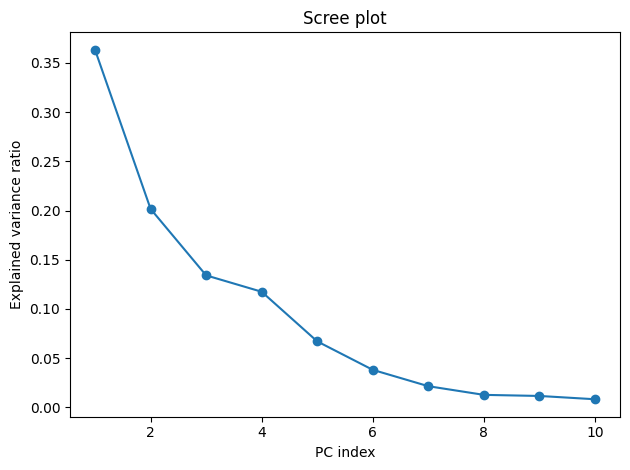

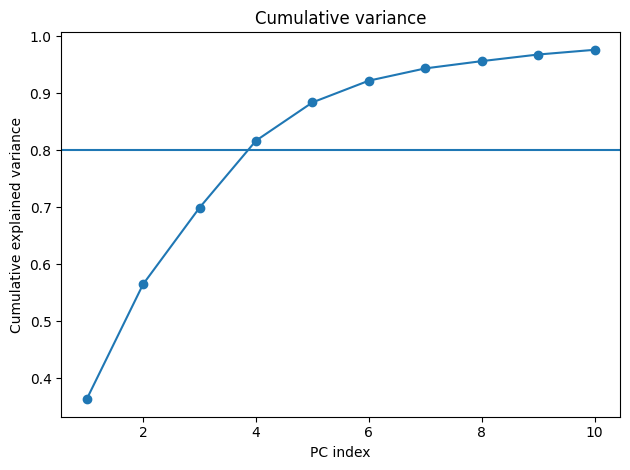

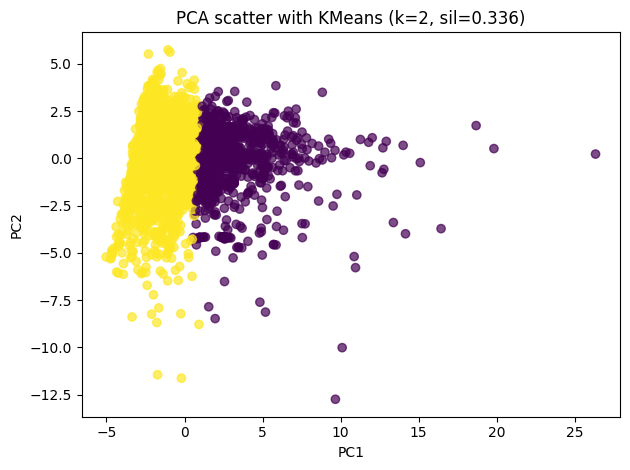

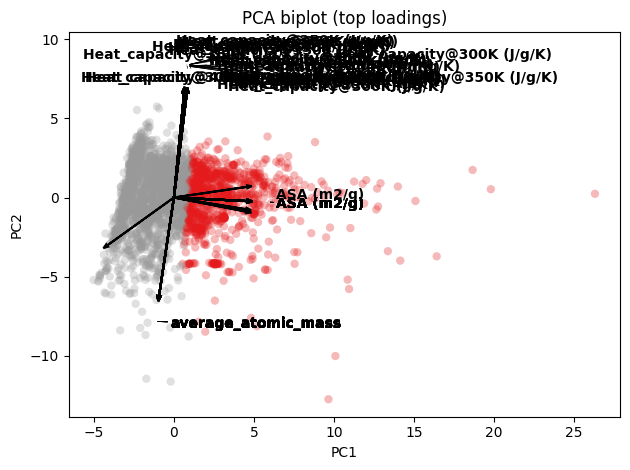

[OK] best k = 2, silhouette = 0.336, n_components = 4
Artifacts:
 - Assignments CSV: data_core\cif\CSD-modified\cifs\CR\ASR_pca_kmeans_assignments.csv
 - Loadings CSV: data_core\cif\CSD-modified\cifs\CR\ASR_pca_kmeans_loadings.csv
 - Summary XLSX: data_core\cif\CSD-modified\cifs\CR\ASR_pca_kmeans_summary.xlsx


In [38]:
# analysis/asr_pca_kmeans.py
#!/usr/bin/env python3
"""
PCA + KMeans clustering on ASR_prediction_with_features.csv.

Why:
- Standardize numeric features to remove scale effects.
- PCA reduces dimensionality and denoises; n_components chosen by >=80% variance (cap 10).
- KMeans with silhouette-based k selection gives a reasonable partition.
- Outputs CSVs and basic plots for quick inspection.
"""

from __future__ import annotations
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ------------------------- Config -------------------------
CSV_IN = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")
OUT_PREFIX = Path("data_core/cif/CSD-modified/cifs/CR/ASR_pca_kmeans")  # files: *_assignments.csv, *_loadings.csv, *_summary.xlsx
TARGET = "prediction"

# Numeric features to include (only those present will be used)
NUM_FEATURES = [
    "LCD (Å)","PLD (Å)","LFPD (Å)","Density (g/cm3)",
    "ASA (A2)","ASA (m2/cm3)","ASA (m2/g)",
    "NASA (A2)","NASA (m2/cm3)","NASA (m2/g)",
    "PV (A3)","VF","PV (cm3/g)",
    "NAV (A3)","NAV_VF","NPV (cm3/g)",
    "average_atomic_mass",
    "Heat_capacity@300K (J/g/K)","Heat_capacity@350K (J/g/K)","Heat_capacity@400K (J/g/K)",
    "natoms"
]
ID_COLS_TRY = ["id","refcode","name","mofid-v1","mofid-v2"]

# PCA selection
MAX_COMPONENTS = 10
VAR_THRESHOLD = 0.80  # choose n s.t. cumulative variance >= 0.80 (min 2)

# KMeans selection
K_MIN, K_MAX = 2, 10

# Performance knobs
FAST_MODE = True        # if True, auto-subsample for speed
SUBSAMPLE_N = 3000      # max rows to use if FAST_MODE
RANDOM_STATE = 42

# ----------------------- Load & prepare -----------------------
df = pd.read_csv(CSV_IN)

# ID column detection
id_col = next((c for c in ID_COLS_TRY if c in df.columns), None)
if id_col is None:
    id_col = "row_id"
    df[id_col] = np.arange(len(df))

# keep available numeric
num_cols: List[str] = [c for c in NUM_FEATURES if c in df.columns]
use_cols = [id_col, TARGET] + num_cols
df_use = df[use_cols].copy()

# numeric coercion
for c in num_cols + [TARGET]:
    if c in df_use.columns:
        df_use[c] = pd.to_numeric(df_use[c], errors="coerce")

# drop rows with all-nan features or missing target
mask_valid = df_use[num_cols].notna().any(axis=1) & (~df_use[TARGET].isna())
df_use = df_use.loc[mask_valid].reset_index(drop=True)

# optional subsample
if FAST_MODE and len(df_use) > SUBSAMPLE_N:
    df_use = df_use.sample(n=SUBSAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

# ----------------------- Impute & scale -----------------------
X = df_use[num_cols].to_numpy()
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_imp)

# ----------------------------- PCA -----------------------------
pca = PCA(n_components=min(MAX_COMPONENTS, X_scaled.shape[1]), random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
cum = np.cumsum(explained)
n_opt = int(np.argmax(cum >= VAR_THRESHOLD) + 1) if (cum >= VAR_THRESHOLD).any() else min(3, X_pca.shape[1])
n_opt = max(2, n_opt)
X_p = X_pca[:, :n_opt]

# ----------------------- KMeans model selection -----------------------
sil_scores = []
best_k = None
best_sil = -1.0
best_model = None
best_labels = None

upper_k = min(K_MAX, len(df_use) - 1)
for k in range(K_MIN, max(K_MIN, upper_k) + 1):
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_p)
    if len(set(labels)) < 2:
        sil = -1.0
    else:
        sil = silhouette_score(X_p, labels)
    sil_scores.append((k, sil))
    if sil > best_sil:
        best_k, best_sil, best_model, best_labels = k, sil, km, labels

sil_df = pd.DataFrame(sil_scores, columns=["k","silhouette"]).sort_values("k")

# ------------------------- Outputs: tables -------------------------
assign = pd.DataFrame({
    id_col: df_use[id_col].values,
    "cluster": best_labels,
    "PC1": X_p[:, 0],
    "PC2": X_p[:, 1],
    TARGET: df_use[TARGET].values,
})
# full loadings for all PCs fit
loading_full = pd.DataFrame(
    pca.components_.T,
    index=num_cols,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])],
)

# cluster stats (count/mean/median/std on numeric + target)
cluster_stats = (
    df_use[[id_col, TARGET] + num_cols]
    .merge(assign[[id_col, "cluster"]], on=id_col, how="left")
    .groupby("cluster")[[TARGET] + num_cols]
    .agg(["count","mean","median","std"])
)

# z-score means per cluster for numeric features
z = (df_use[num_cols] - df_use[num_cols].mean()) / df_use[num_cols].std(ddof=0)
z["cluster"] = best_labels
z_mean = z.groupby("cluster").mean().reset_index()

# write files
assign.to_csv(OUT_PREFIX.with_name(OUT_PREFIX.name + "_assignments.csv"), index=False)
loading_full.to_csv(OUT_PREFIX.with_name(OUT_PREFIX.name + "_loadings.csv"))
with pd.ExcelWriter(OUT_PREFIX.with_name(OUT_PREFIX.name + "_summary.xlsx")) as xw:
    sil_df.to_excel(xw, sheet_name="k_silhouette", index=False)
    assign.to_excel(xw, sheet_name="assignments", index=False)
    cluster_stats.to_excel(xw, sheet_name="cluster_profile")
    z_mean.to_excel(xw, sheet_name="cluster_mean_z", index=False)

# ----------------------------- Plots -----------------------------
# Scree
plt.figure()
plt.plot(np.arange(1, len(explained)+1), explained, marker="o")
plt.xlabel("PC index")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.tight_layout()
plt.show()

# Cumulative variance
plt.figure()
plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
plt.axhline(VAR_THRESHOLD)
plt.xlabel("PC index")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative variance")
plt.tight_layout()
plt.show()

# PCA scatter with clusters
plt.figure()
plt.scatter(X_p[:,0], X_p[:,1], c=best_labels, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA scatter with KMeans (k={best_k}, sil={best_sil:.3f})")
plt.tight_layout()
plt.show()

# Biplot with top loadings on PC1/PC2
loadings_2d = pca.components_.T[:, :2]
# loading_df = pd.DataFrame(loadings_2d, index=num_cols, columns=["PC1","PC2"])
# 挑出 PC1 或 PC2 方向上 loading 值最大的一些变量（避免重叠）
loading_df = pd.DataFrame(loadings_2d, index=num_cols, columns=["PC1","PC2"])
top_vars = loading_df.loc[(loading_df["PC1"].abs() > 0.3) | (loading_df["PC2"].abs() > 0.3)]
top_vars = top_vars.reindex(top_vars.abs().max(axis=1).sort_values(ascending=False).head(5).index)

top_load = loading_df.reindex(loading_df.abs().max(axis=1).sort_values(ascending=False).head(10).index)


plt.figure()
plt.scatter(X_p[:, 0], X_p[:, 1], c=best_labels, alpha=0.3, cmap="Set1", edgecolor="none")
scale = 15 # 适当放大箭头长度
for feat, row in top_load.iterrows():
    x, y = row["PC1"]*scale, row["PC2"]*scale
    plt.arrow(0, 0, x, y, head_width=0.2, length_includes_head=True, color="black", lw=1.5)
    # plt.text(x*1.1, y*1.1, feat, fontsize=7, color='black')
    from adjustText import adjust_text

    texts = []
    for feat, row in top_vars.iterrows():
       x, y = row["PC1"] * scale, row["PC2"] * scale
       plt.arrow(0, 0, x, y, head_width=0.2, length_includes_head=True, color="black", lw=1.5)
       texts.append(plt.text(x * 1.2, y * 1.2, feat, fontsize=10, weight='bold'))

# 自动避免文字重叠
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA biplot (top loadings)")
plt.tight_layout()
plt.show()

print(f"[OK] best k = {best_k}, silhouette = {best_sil:.3f}, n_components = {n_opt}")
print("Artifacts:")
print(" - Assignments CSV:", OUT_PREFIX.with_name(OUT_PREFIX.name + "_assignments.csv"))
print(" - Loadings CSV:", OUT_PREFIX.with_name(OUT_PREFIX.name + "_loadings.csv"))
print(" - Summary XLSX:", OUT_PREFIX.with_name(OUT_PREFIX.name + "_summary.xlsx"))


In [ ]:
# /scripts/run_mof_hts.py
from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Optional, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================= Paths =======================
INPUT_CSV = Path("/mnt/data/ASR_prediction_with_features.csv")
OUT_DIR = Path("/mnt/data/asr_hts_outputs_adaptive_aligned")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ======================= Columns =======================
PRED_COL = "prediction"
NUM_FEATURES = [
    "LCD (Å)", "PLD (Å)", "LFPD (Å)", "Density (g/cm3)",
    "ASA (A2)", "ASA (m2/cm3)", "ASA (m2/g)",
    "NASA (A2)", "NASA (m2/cm3)", "NASA (m2/g)",
    "PV (A3)", "VF", "PV (cm3/g)",
    "NAV (A3)", "NAV_VF", "NPV (cm3/g)",
    "average_atomic_mass", "natoms",
]
CAT_FEATURES = [
    "topology(AllNodes)", "topology(SingleNodes)",
    "structure_dimension", "Metal Types", "Has OMS", "OMS Types",
    "Water_stability", "Solvent_stability"
]
ID_COLS_TRY = ["id", "refcode", "name", "mofid-v1", "mofid-v2"]

# =================== Thresholds ===================
INIT   = dict(PLD_MIN=3.4, LCD_MIN=6.0, VF_MIN=0.35, PVG_MIN=0.50, ASA_MIN=600.0, DENSITY_MAX=1.00)
BOUNDS = dict(PLD_MIN=3.0, LCD_MIN=5.0, VF_MIN=0.25, PVG_MIN=0.30, ASA_MIN=400.0, DENSITY_MAX=1.20)
STEPS  = dict(PLD_MIN=-0.2, LCD_MIN=-0.5, VF_MIN=-0.03, PVG_MIN=-0.05, ASA_MIN=-50.0, DENSITY_MAX=+0.05)
MAX_RELAX_ROUNDS = 8
MIN_POOL = 150
USE_STABILITY = False
THERMAL_MIN_C = 250.0

# =================== Scoring ===================
W_PRED_ALIGNED = 0.85
W_AUX = 0.40
EPS = 1e-6

# =================== Diversity & Outputs ===================
K_PER_TOPOLOGY = 8
USE_SECONDARY_METAL_DEDUP = True
TOP_N_GLOBAL = 500
TOP_N_SHORTLIST = 150

# ======================= Helpers =======================
def _coerce_float(df: pd.DataFrame, cols: Iterable[str]) -> None:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def _first_existing_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _rank01(s: pd.Series, ascending: bool) -> pd.Series:
    r = s.rank(method="average", ascending=ascending, na_option="keep")
    if r.notna().any():
        den = (r.max() - r.min())
        return (r - r.min()) / den if den and den != 0 else pd.Series(0.5, index=r.index)
    return r

def _spearman_corr(a: pd.Series, b: pd.Series) -> float:
    ra = a.rank(method="average", na_option="keep")
    rb = b.rank(method="average", na_option="keep")
    m = (~ra.isna()) & (~rb.isna())
    return float(ra[m].corr(rb[m])) if m.sum() > 3 else 0.0

def _apply_constraints(df: pd.DataFrame, thr: Dict[str, float], use_stability: bool = False) -> pd.Series:
    def has(c: str) -> bool: return c in df.columns
    mask = pd.Series(True, index=df.index)
    if has("PLD (Å)"):            mask &= (df["PLD (Å)"] >= thr["PLD_MIN"])
    if has("LCD (Å)"):            mask &= (df["LCD (Å)"] >= thr["LCD_MIN"])
    if has("VF"):                 mask &= (df["VF"] >= thr["VF_MIN"])
    if has("PV (cm3/g)"):         mask &= (df["PV (cm3/g)"] >= thr["PVG_MIN"])
    if has("ASA (m2/g)"):         mask &= (df["ASA (m2/g)"] >= thr["ASA_MIN"])
    if has("Density (g/cm3)"):    mask &= (df["Density (g/cm3)"] <= thr["DENSITY_MAX"])
    if use_stability:
        if "Thermal_stability (℃)" in df.columns:
            mask &= (pd.to_numeric(df["Thermal_stability (℃)"], errors="coerce") >= THERMAL_MIN_C)
        if "Water_stability" in df.columns:
            mask &= df["Water_stability"].astype(str).str.lower().str.contains("stable", na=False)
        if "Solvent_stability" in df.columns:
            mask &= df["Solvent_stability"].astype(str).str.lower().str.contains("stable", na=False)
    return mask.fillna(False)

def _relax_once(thr: Dict[str, float]) -> Dict[str, float]:
    new_thr = thr.copy()
    for k, step in STEPS.items():
        if k == "DENSITY_MAX":
            new_thr[k] = min(thr[k] + step, BOUNDS["DENSITY_MAX"])
        else:
            new_thr[k] = max(thr[k] + step, BOUNDS[k])
    return new_thr

def _quantile_fallback(df: pd.DataFrame, thr: Dict[str, float]) -> Dict[str, float]:
    out = thr.copy()
    def q(col: str, qv: float) -> Optional[float]:
        if col in df.columns and df[col].notna().any():
            return float(df[col].quantile(qv))
        return None
    for key, col in [("PLD_MIN","PLD (Å)"),("LCD_MIN","LCD (Å)"),
                     ("VF_MIN","VF"),("PVG_MIN","PV (cm3/g)"),
                     ("ASA_MIN","ASA (m2/g)")]:
        v = q(col, 0.10)
        if v is not None:
            out[key] = max(min(out[key], v), BOUNDS[key])
    v90 = q("Density (g/cm3)", 0.90)
    if v90 is not None:
        out["DENSITY_MAX"] = min(max(out["DENSITY_MAX"], v90), BOUNDS["DENSITY_MAX"])
    return out

def _diversity_shortlist(pool: pd.DataFrame, top_n: int) -> pd.DataFrame:
    if pool is None or pool.empty:
        return pool.head(0).copy() if pool is not None else pd.DataFrame()
    topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
    strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)
    if strata_col:
        picks: List[pd.DataFrame] = []
        for _, g in pool.groupby(strata_col, dropna=False):
            if g.empty:
                continue
            g_sorted = g.sort_values("score", ascending=False)
            if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
                seen: set = set()
                picked = []
                for _, row in g_sorted.iterrows():
                    m = str(row["Metal Types"])
                    if m not in seen:
                        picked.append(row); seen.add(m)
                    if len(picked) >= K_PER_TOPOLOGY:
                        break
                sub = pd.DataFrame(picked)
            else:
                sub = g_sorted.head(K_PER_TOPOLOGY)
            if not sub.empty:
                picks.append(sub)
        sl = pd.concat(picks, ignore_index=True) if picks else pool.head(top_n).copy()
    else:
        sl = pool.head(top_n).copy()
    return sl.sort_values("score", ascending=False).head(top_n).copy()

# ======================= Run =======================
df = pd.read_csv(INPUT_CSV, low_memory=False)
id_col = _first_existing_col(df, ID_COLS_TRY) or "row_id"
if id_col not in df.columns:
    df[id_col] = np.arange(len(df))
num_cols = [c for c in NUM_FEATURES if c in df.columns]
cat_cols = [c for c in CAT_FEATURES if c in df.columns]
cols = [id_col, PRED_COL] + num_cols + cat_cols
df = df[[c for c in cols if c in df.columns]].copy()
extra_num = ["Thermal_stability (℃)"] if "Thermal_stability (℃)" in df.columns else []
_coerce_float(df, [PRED_COL] + num_cols + extra_num)
df = df.loc[~df[PRED_COL].isna()].copy()

thr = INIT.copy()
mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
round_idx = 0
while (not mask.any()) and round_idx < MAX_RELAX_ROUNDS:
    round_idx += 1
    thr = _relax_once(thr)
    mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
if not mask.any():
    thr = _quantile_fallback(df, thr)
    mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
if not mask.any():
    thr = dict(PLD_MIN=max(BOUNDS["PLD_MIN"], 3.0),
               LCD_MIN=BOUNDS["LCD_MIN"],
               VF_MIN=BOUNDS["VF_MIN"],
               PVG_MIN=BOUNDS["PVG_MIN"],
               ASA_MIN=BOUNDS["ASA_MIN"],
               DENSITY_MAX=BOUNDS["DENSITY_MAX"])
    mask = _apply_constraints(df, thr, use_stability=False)
if "Density (g/cm3)" in df.columns and mask.any():
    while mask.sum() < MIN_POOL and thr["DENSITY_MAX"] < BOUNDS["DENSITY_MAX"]:
        thr["DENSITY_MAX"] = min(thr["DENSITY_MAX"] + 0.05, BOUNDS["DENSITY_MAX"])
        mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

POS_FEATS = [c for c in ["VF", "PV (cm3/g)", "ASA (m2/g)"] if c in df.columns]
DENS_FEAT = "Density (g/cm3)" if "Density (g/cm3)" in df.columns else None
y = pd.to_numeric(df[PRED_COL], errors="coerce")
pred_rank_desc = _rank01(y, ascending=False).fillna(0.5)
pred_rank_asc  = _rank01(y, ascending=True ).fillna(0.5)
rho_desc = _spearman_corr(y, pred_rank_desc)
rho_asc  = _spearman_corr(y, pred_rank_asc)
if rho_desc >= rho_asc:
    pred_rank = pred_rank_desc
    rho_pred_only = rho_desc
else:
    pred_rank = pred_rank_asc
    rho_pred_only = rho_asc

corrs: Dict[str, float] = {}
aux_terms = []
for c in POS_FEATS:
    x = pd.to_numeric(df[c], errors="coerce")
    r = _rank01(x, ascending=False).fillna(0.5)
    rho = _spearman_corr(y, x)
    corrs[c] = rho
    sgn = np.sign(rho)  # why: 保证与预测的单调方向一致/相反以提升一致性
    if sgn != 0:
        aux_terms.append(sgn * r)
if DENS_FEAT:
    x = pd.to_numeric(df[DENS_FEAT], errors="coerce")
    r = _rank01(x, ascending=False).fillna(0.5)
    rho = _spearman_corr(y, x)
    corrs[DENS_FEAT] = rho
    sgn = -1.0 if rho == 0 else -np.sign(rho)  # why: 密度若与预测正相关则必须做惩罚
    aux_terms.append(sgn * r)
if aux_terms:
    aux_block = pd.Series(np.nanmean(np.vstack(aux_terms), axis=0), index=df.index)
else:
    aux_block = pd.Series(0.0, index=df.index)
score_combo = W_PRED_ALIGNED * pred_rank + W_AUX * aux_block
rho_combo = _spearman_corr(y, score_combo)
if (rho_combo + EPS) < rho_pred_only or rho_combo < 0:
    df["score"] = pred_rank.copy()
else:
    df["score"] = score_combo

pool = df.loc[mask].copy().sort_values("score", ascending=False)
df.sort_values("score", ascending=False).head(TOP_N_GLOBAL).to_csv(OUT_DIR / "global_topN_scored.csv", index=False)
pool.to_csv(OUT_DIR / "pool_pass_constraints.csv", index=False)

topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)
if strata_col and not pool.empty:
    shortlist_rows: List[pd.DataFrame] = []
    for _, g in pool.groupby(strata_col, dropna=False):
        g_sorted = g.sort_values("score", ascending=False)
        if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
            seen: set = set()
            picked = []
            for _, row in g_sorted.iterrows():
                m = str(row["Metal Types"])
                if m not in seen:
                    picked.append(row); seen.add(m)
                if len(picked) >= K_PER_TOPOLOGY:
                    break
            sub = pd.DataFrame(picked)
        else:
            sub = g_sorted.head(K_PER_TOPOLOGY)
        if not sub.empty:
            shortlist_rows.append(sub)
    shortlist = pd.concat(shortlist_rows, ignore_index=True) if shortlist_rows else pool.head(TOP_N_SHORTLIST).copy()
else:
    shortlist = pool.head(TOP_N_SHORTLIST).copy()
shortlist = shortlist.sort_values("score", ascending=False).head(TOP_N_SHORTLIST).copy()
shortlist.to_csv(OUT_DIR / "shortlist_diverse.csv", index=False)

objs = []; maximize = []
if PRED_COL in pool.columns:      objs.append(pool[PRED_COL].to_numpy(float));      maximize.append(True)
if "PV (cm3/g)" in pool.columns:  objs.append(pool["PV (cm3/g)"].to_numpy(float));  maximize.append(True)
if "VF" in pool.columns:          objs.append(pool["VF"].to_numpy(float));          maximize.append(True)
if "ASA (m2/g)" in pool.columns:  objs.append(pool["ASA (m2/g)"].to_numpy(float));  maximize.append(True)
if "Density (g/cm3)" in pool.columns:
    objs.append(pool["Density (g/cm3)"].to_numpy(float));                            maximize.append(False)
if objs:
    A = np.vstack(objs).T
    B = A.copy()
    for j, is_max in enumerate(maximize):
        if is_max:
            B[:, j] = -B[:, j]
    n = B.shape[0]; eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not eff[i]: 
            continue
        dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1)
        dom[i] = False
        if dom.any():
            eff[i] = False
    pareto = pool.loc[eff].copy().sort_values("score", ascending=False)
else:
    pareto = pd.DataFrame(columns=list(pool.columns))
pareto.to_csv(OUT_DIR / "pareto_front.csv", index=False)

df.sort_values("score", ascending=False).to_csv(OUT_DIR / "full_scored_with_flags.csv", index=False)

# Plots (one figure each; default style/colors)
plt.figure(); df[PRED_COL].dropna().plot(kind="hist", bins=50, title="Prediction Distribution")
plt.xlabel("prediction"); plt.ylabel("count"); plt.tight_layout()
plt.savefig(OUT_DIR / "fig_prediction_hist.png"); plt.close()

plt.figure(); df["score"].dropna().plot(kind="hist", bins=50, title="Score Distribution")
plt.xlabel("score"); plt.ylabel("count"); plt.tight_layout()
plt.savefig(OUT_DIR / "fig_score_hist.png"); plt.close()

plt.figure(); plt.scatter(df[PRED_COL], df["score"])
plt.title("Prediction vs Score"); plt.xlabel("prediction"); plt.ylabel("score"); plt.tight_layout()
plt.savefig(OUT_DIR / "fig_pred_vs_score.png"); plt.close()

if "topology(AllNodes)" in shortlist.columns:
    top_counts = shortlist["topology(AllNodes)"].astype(str).value_counts().head(20)
    plt.figure(); top_counts.plot(kind="bar", title="Topologies in Shortlist (Top 20)")
    plt.xlabel("topology(AllNodes)"); plt.ylabel("count"); plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_topology_counts_shortlist.png"); plt.close()

if "Density (g/cm3)" in df.columns:
    plt.figure(); plt.scatter(df["Density (g/cm3)"], df["score"])
    plt.title("Density vs Score"); plt.xlabel("Density (g/cm3)"); plt.ylabel("score"); plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_density_vs_score.png"); plt.close()

if "VF" in df.columns:
    plt.figure(); plt.scatter(df["VF"], df["score"])
    plt.title("VF vs Score"); plt.xlabel("VF"); plt.ylabel("score"); plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_vf_vs_score.png"); plt.close()

if "PV (cm3/g)" in df.columns:
    plt.figure(); plt.scatter(df["PV (cm3/g)"], df["score"])
    plt.title("PV (cm3/g) vs Score"); plt.xlabel("PV (cm3/g)"); plt.ylabel("score"); plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_pv_vs_score.png"); plt.close()

if "ASA (m2/g)" in df.columns:
    plt.figure(); plt.scatter(df["ASA (m2/g)"], df["score"])
    plt.title("ASA (m2/g) vs Score"); plt.xlabel("ASA (m2/g)"); plt.ylabel("score"); plt.tight_layout()
    plt.savefig(OUT_DIR / "fig_asa_vs_score.png"); plt.close()
